# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разработанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['legend.frameon'] = True
palette = sns.color_palette('Set1')
sns.set_palette(palette)

### Подгружаем данные

In [3]:
!wget -q https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget -q https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget -q https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

In [4]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Описание данных

In [5]:
desc_df.drop('desc_eng', axis=1, inplace=True)
desc_df

,field,desc_rus
0,ar_revenue,Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Общие расходы за последний год
2,ar_sale_cost,Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Валовая прибыль (на конец последнего года)
8,ar_taxes,Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [6]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [7]:
train_df.shape, test_df.shape

((32395, 37), (200, 36))

Количество разных типов признаков.

In [8]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

In [9]:
train_df.drop('record_id', axis=1, inplace=True)

### Выбор метрики

Уровень дефолт-рейта в выборке.

In [10]:
train_df['default_12m'].values.mean()

0.06454699799351751

Видно, что выборка является сильно несбалансированной по таргету. Это значит, что использовать `accuracy` в качестве метрики качества классификации нельзя, потому что можно выбрать константный прогноз `y=0` и получить значение метрики свыше 0.9:

In [11]:
import numpy as np
y_train = train_df['default_12m']
y_pred = np.zeros(y_train.shape)
accuracy_score(y_train, y_pred) * 100

93.54530020064826

Вместо этого я предлагаю использовать [коэффициент Коэна](https://en.wikipedia.org/wiki/Cohen%27s_kappa) (каппа Коэна, Cohen's kappa), представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_0 - p_e}{1 - p_e},$$

где $p_e$ здесь -- доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей, а $p_0$ -- доля верных ответов или доля согласованных предсказаний, или `accuracy`. Метрика выступает в качестве меры согласованности между двумя независимыми предсказателями.

Для категории $k$ и двух экспертов $n_{ki}$ определяется как число раз, когда эксперт $i$ предсказал категорию $k$, тогда:

$$p_e = \frac{1}{n^2}\sum\limits_{k} n_{1k} \cdot n_{2k},$$

$\kappa = 0$, когда $ROC-AUC = 0.5$, $\kappa = 1$ или $-1$ при полной согласованности и несогласованности соответственно.

Как будет оцениваться качество на тесте в лидерборде -- авторам виднее, но по-хорошему для таких задач использовать `accuracy` нельзя.

In [12]:
def ck_coeff(y: np.array, y_proba: np.array, treshold=None, mode='preds'):
    n = y.shape[0]
    if mode == 'proba':
        assert treshold is not None
        y_preds = (y_proba >= treshold).astype(int)
    elif mode == 'preds':
        y_preds = y_proba.copy()
    else:
        raise ValueError('Unknown mode')
        
    p0 = accuracy_score(y, y_preds)
    tmp0 = np.count_nonzero(y) * np.count_nonzero(y_preds)
    tmp1 = (n - np.count_nonzero(y)) * (n - np.count_nonzero(y_preds))
    pe = (tmp0 + tmp1) / n ** 2
    return (p0 - pe) / (1 - pe)

### EDA

Первое, что я хочу сделать -- уменьшить признаковое пространство с помощью EDA на некотором базовом уровне. Основная задача сейчас -- определение незначимых признаков.

Посмотрим, сколько в выборке пропущенных значений.

In [13]:
train_df.isna().sum() / train_df.shape[0] * 100

ar_revenue                      46.751042
ar_total_expenses               46.751042
ar_sale_cost                    46.751042
ar_selling_expenses             46.751042
ar_management_expenses          46.751042
ar_sale_profit                  46.751042
ar_balance_of_rvns_and_expns    46.751042
ar_profit_before_tax            46.751042
ar_taxes                        46.751042
ar_other_profit_and_losses      46.751042
ar_net_profit                   46.751042
ab_immobilized_assets           46.751042
ab_mobile_current_assets        46.751042
ab_inventory                    46.751042
ab_accounts_receivable          46.751042
ab_other_current_assets         46.751042
ab_cash_and_securities          46.751042
ab_losses                       46.751042
ab_own_capital                  46.751042
ab_borrowed_capital             46.751042
ab_long_term_liabilities        46.751042
ab_short_term_borrowing         46.751042
ab_accounts_payable             46.751042
ab_other_borrowings             46

В большом числе признаков практически половина значений пропущена. Пока что здесь особых выводов не сделаешь, но это уже создает проблему с распределениями.

In [14]:
train_df.describe()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
count,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,...,32395.000000,32395.000000,32395.000000,32395.000000,3.239500e+04,32395.000000,32395.000000,32395.000000,32395.0,32395.000000
mean,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,4.188071e+05,3.937304e+04,...,78.644822,15.010341,15.010341,15.010341,1.366509e+06,11.946535,0.021670,0.000093,0.0,0.064547
std,1.274402e+08,1.227227e+08,1.156651e+08,1.231798e+07,7.848929e+06,1.941027e+07,6.014715e+06,1.938021e+07,1.565298e+06,4.843389e+05,...,46.522534,9.546511,9.546511,9.546511,1.502438e+07,86.341847,0.342715,0.009623,0.0,0.245729
min,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,-1.034000e+07,...,0.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.0,0.000000
25%,1.019950e+07,9.130250e+06,8.844000e+06,0.000000e+00,0.000000e+00,2.112500e+05,-9.400000e+05,1.420000e+05,0.000000e+00,0.000000e+00,...,35.000000,6.000000,6.000000,6.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
50%,3.233500e+07,2.970350e+07,2.840800e+07,0.000000e+00,0.000000e+00,1.231500e+06,-1.260000e+05,8.500000e+05,4.100000e+04,0.000000e+00,...,77.000000,14.000000,14.000000,14.000000,1.000000e+04,1.000000,0.000000,0.000000,0.0,0.000000
75%,8.887675e+07,8.309500e+07,7.991425e+07,0.000000e+00,0.000000e+00,4.574750e+06,0.000000e+00,3.543750e+06,2.910000e+05,0.000000e+00,...,133.000000,24.000000,24.000000,24.000000,3.000000e+04,2.000000,0.000000,0.000000,0.0,0.000000
max,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,3.979500e+07,...,149.000000,33.000000,33.000000,33.000000,1.584979e+09,998.000000,20.000000,1.000000,0.0,1.000000


Есть признак, который имеет лишь одно уникальное значение -- удаляем.

In [15]:
to_drop = ['ul_systematizing_flg']
train_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

#### Анализ распределений непрерывных признаков.

In [16]:
floats = train_df.select_dtypes(include=float).columns
inds = desc_df[desc_df.field.isin(floats)].index
desc_floats = desc_df.loc[inds]
train_df[floats].describe()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,ul_capital_sum
count,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,...,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,3.239500e+04
mean,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,4.188071e+05,3.937304e+04,...,8.096597e+05,1.610857e+06,3.307750e+06,1.911815e+07,2.419023e+07,3.149311e+06,4.983973e+06,1.508316e+07,9.737877e+05,1.366509e+06
std,1.274402e+08,1.227227e+08,1.156651e+08,1.231798e+07,7.848929e+06,1.941027e+07,6.014715e+06,1.938021e+07,1.565298e+06,4.843389e+05,...,8.222404e+06,1.067265e+07,8.895007e+06,4.603456e+07,5.917809e+07,2.764231e+07,1.359236e+07,3.793929e+07,1.493730e+07,1.502438e+07
min,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,-1.034000e+07,...,-3.413000e+06,0.000000e+00,-4.780300e+07,-7.501000e+07,0.000000e+00,-3.068000e+06,-2.700000e+06,0.000000e+00,-2.500000e+05,0.000000e+00
25%,1.019950e+07,9.130250e+06,8.844000e+06,0.000000e+00,0.000000e+00,2.112500e+05,-9.400000e+05,1.420000e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,4.100000e+04,9.400000e+04,4.532500e+05,1.634000e+06,0.000000e+00,0.000000e+00,6.722500e+05,0.000000e+00,1.000000e+04
50%,3.233500e+07,2.970350e+07,2.840800e+07,0.000000e+00,0.000000e+00,1.231500e+06,-1.260000e+05,8.500000e+05,4.100000e+04,0.000000e+00,...,0.000000e+00,2.640000e+05,6.730000e+05,3.528000e+06,7.231000e+06,0.000000e+00,3.610000e+05,3.678000e+06,0.000000e+00,1.000000e+04
75%,8.887675e+07,8.309500e+07,7.991425e+07,0.000000e+00,0.000000e+00,4.574750e+06,0.000000e+00,3.543750e+06,2.910000e+05,0.000000e+00,...,0.000000e+00,1.188500e+06,3.025750e+06,1.760775e+07,2.541800e+07,0.000000e+00,3.816750e+06,1.424575e+07,0.000000e+00,3.000000e+04
max,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,3.979500e+07,...,3.336220e+08,1.271337e+09,2.470140e+08,1.739879e+09,3.349389e+09,2.919676e+09,3.223740e+08,1.820521e+09,1.251578e+09,1.584979e+09


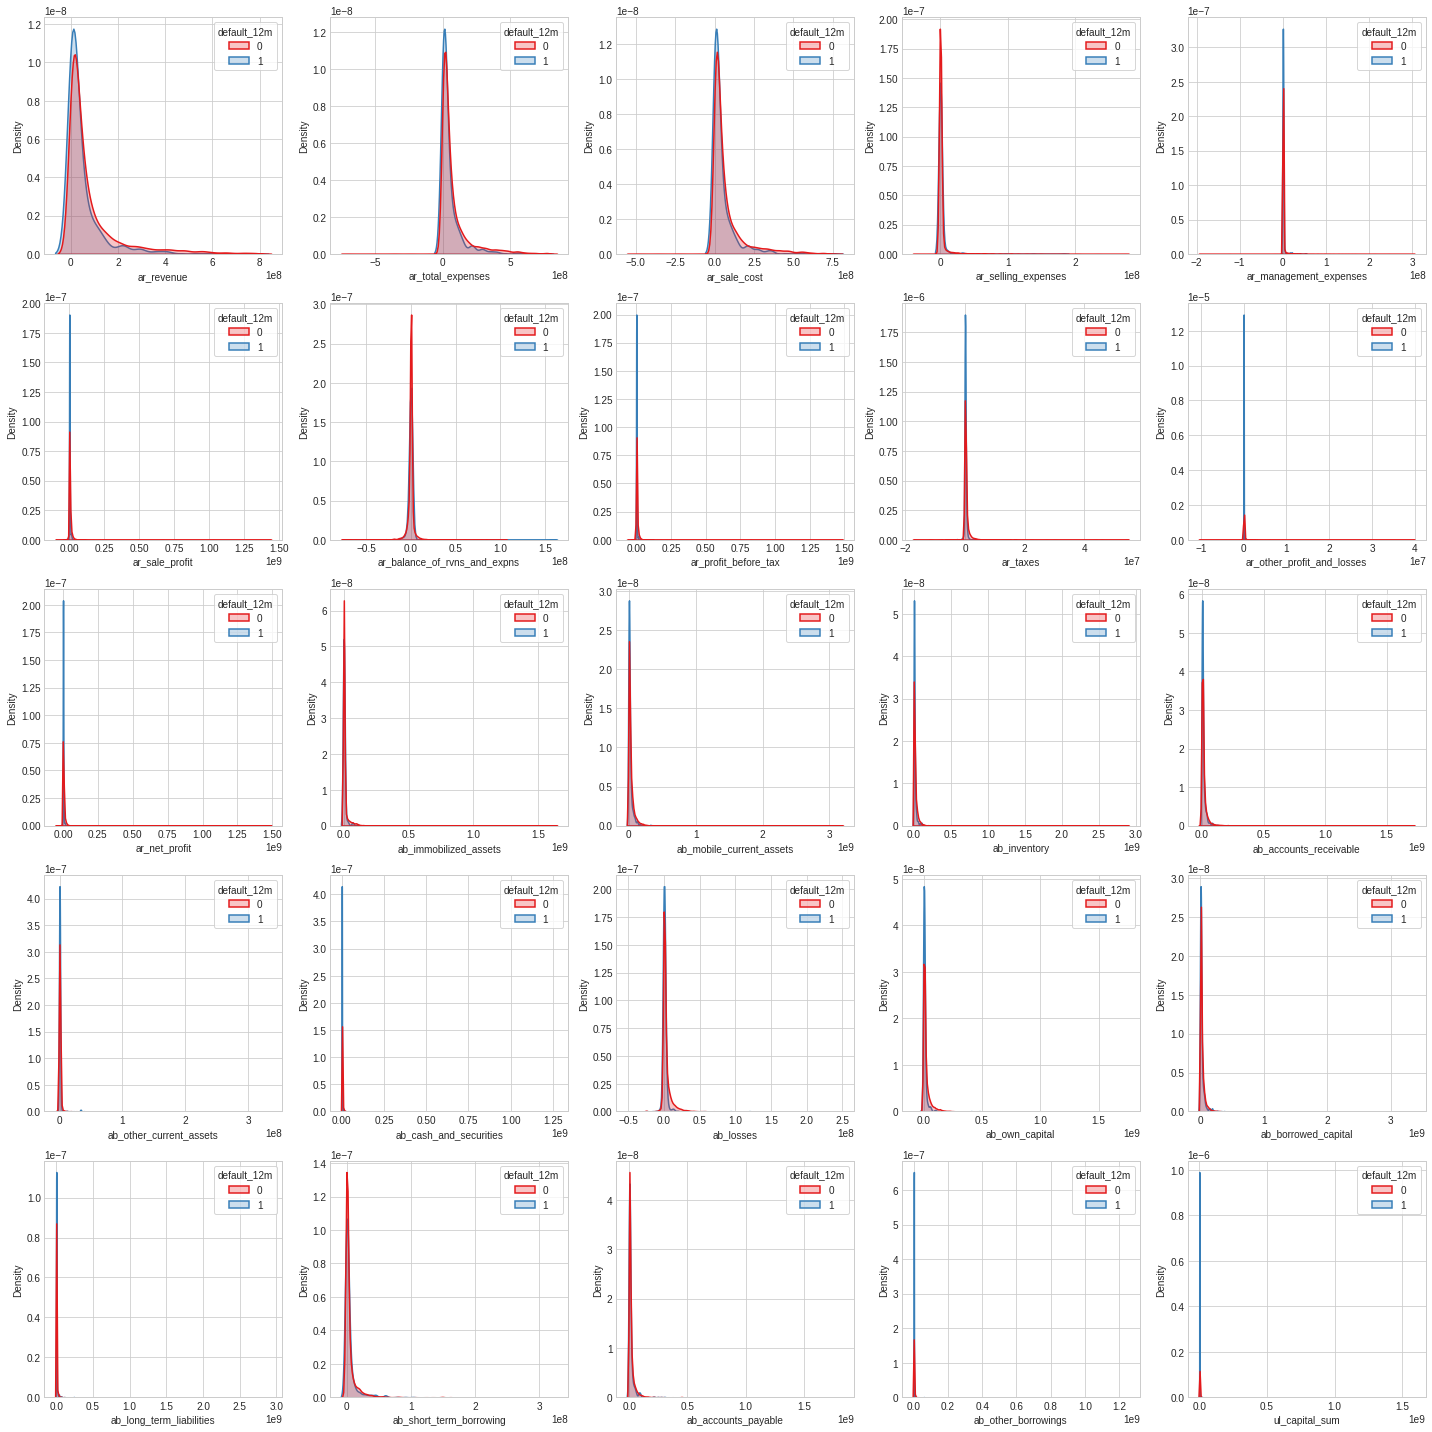

In [17]:
def plot_floats(train_df, features, nrows=5, ncols=5, figsize=(20, 20)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        slice_df = train_df[~train_df[colname].isna()][colname]
        # ax.hist(slice_df, bins=70)
        y = train_df['default_12m'].loc[slice_df.index]
        sns.kdeplot(x=slice_df, hue=y, fill=True, linewidth=1.5, common_norm=False, ax=ax)
        ax.set_xlabel(colname)

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


plot_floats(train_df, floats)

Практически все распределения имеют тяжелые хвосты, а значит, могут быть и выбросы, или же значения, которые встречаются слишком часто.

Давайте попробуем пологорифмировать распределения -- часто преобразование Бокса-Кокса (или нечто подобное) помогает в таких случаях. Логарифмируем каждый признак со сдвигом на абсолютную величину его минимального значения.

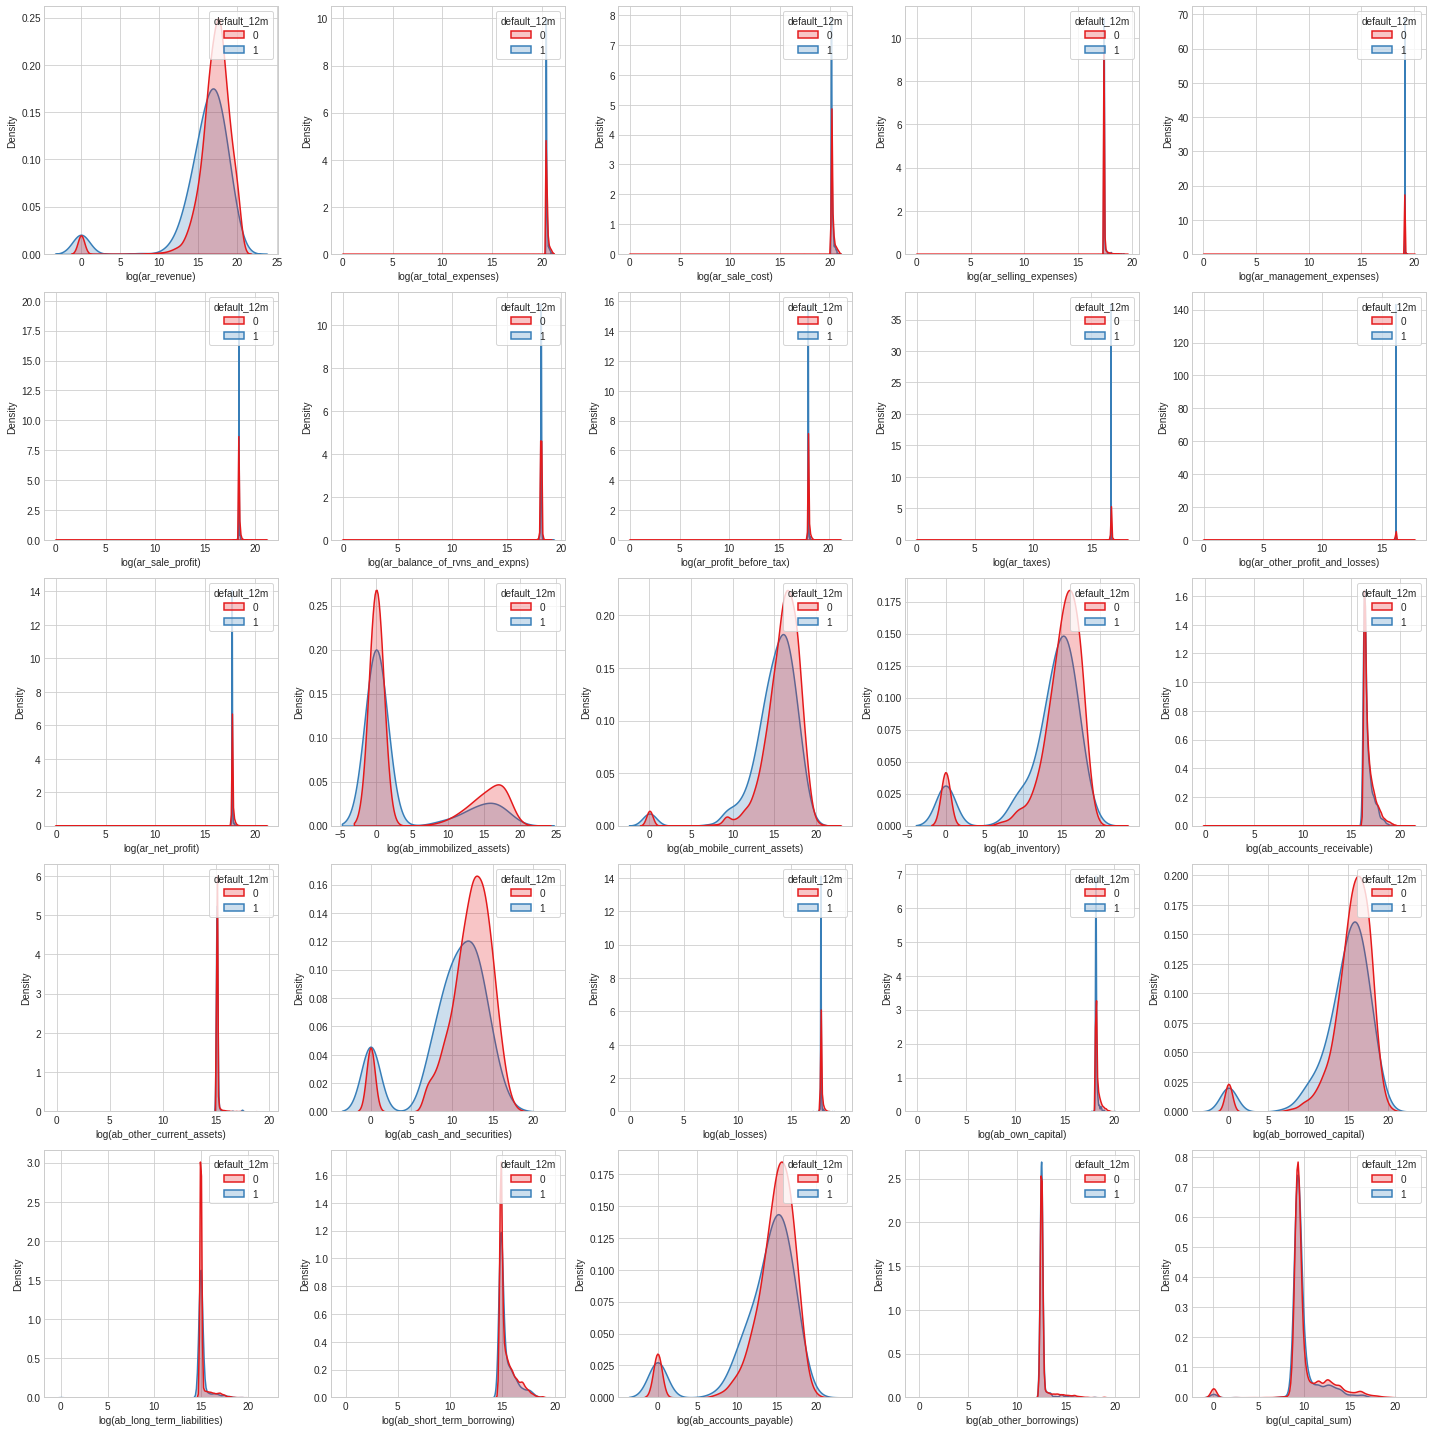

In [18]:
def plot_logged_floats(train_df, features, nrows=5, ncols=5, figsize=(20, 20)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        slice_df = train_df[~train_df[colname].isna()][colname]
        slice_df = np.log(slice_df + np.abs(slice_df.min()) + 1)
        y = train_df['default_12m'].loc[slice_df.index]
        sns.kdeplot(x=slice_df, hue=y, fill=True, linewidth=1.5, common_norm=False, ax=ax)
        ax.set_xlabel(f'log({colname})')

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_logged_floats(train_df, floats)

Есть некоторые разумные признаки, однако практически во всех есть нулевой столбец. Имеет смысл заполнить пропущенные значения также нулем как значением, которое индентифицирует отсутствие информации. Это вполне разумно: в задачах кредитного скоринга, дефолта или оттока нередка ситуация, когда нет информации по той или иной статистике.

Также можно заметить, что в некоторых признаках значение моды соответствует положительному классу.

Выведем моды этих признаков.

In [19]:
for colname in floats:
    print(colname, ': {}'.format(train_df[colname].mode()[0]))

ar_revenue : 0.0
ar_total_expenses : 0.0
ar_sale_cost : 0.0
ar_selling_expenses : 0.0
ar_management_expenses : 0.0
ar_sale_profit : 0.0
ar_balance_of_rvns_and_expns : 0.0
ar_profit_before_tax : 0.0
ar_taxes : 0.0
ar_other_profit_and_losses : 0.0
ar_net_profit : 0.0
ab_immobilized_assets : 0.0
ab_mobile_current_assets : 0.0
ab_inventory : 0.0
ab_accounts_receivable : 0.0
ab_other_current_assets : 0.0
ab_cash_and_securities : 0.0
ab_losses : 0.0
ab_own_capital : 10000.0
ab_borrowed_capital : 0.0
ab_long_term_liabilities : 0.0
ab_short_term_borrowing : 0.0
ab_accounts_payable : 0.0
ab_other_borrowings : 0.0
ul_capital_sum : 10000.0


Действительно: только у двух из этих признаков мода отлична от нуля. 

Заполним пропущенные значения нулям и выведем распределения ненулевых значений этих признаков.

In [20]:
train_df[['ab_own_capital', 'ul_capital_sum']].isna().sum()

ab_own_capital    15145
ul_capital_sum        0
dtype: int64

In [21]:
from sklearn.impute import SimpleImputer
train_df[floats] = SimpleImputer(strategy='most_frequent').fit_transform(train_df[floats])

Выведем распределения без нулевых значений.

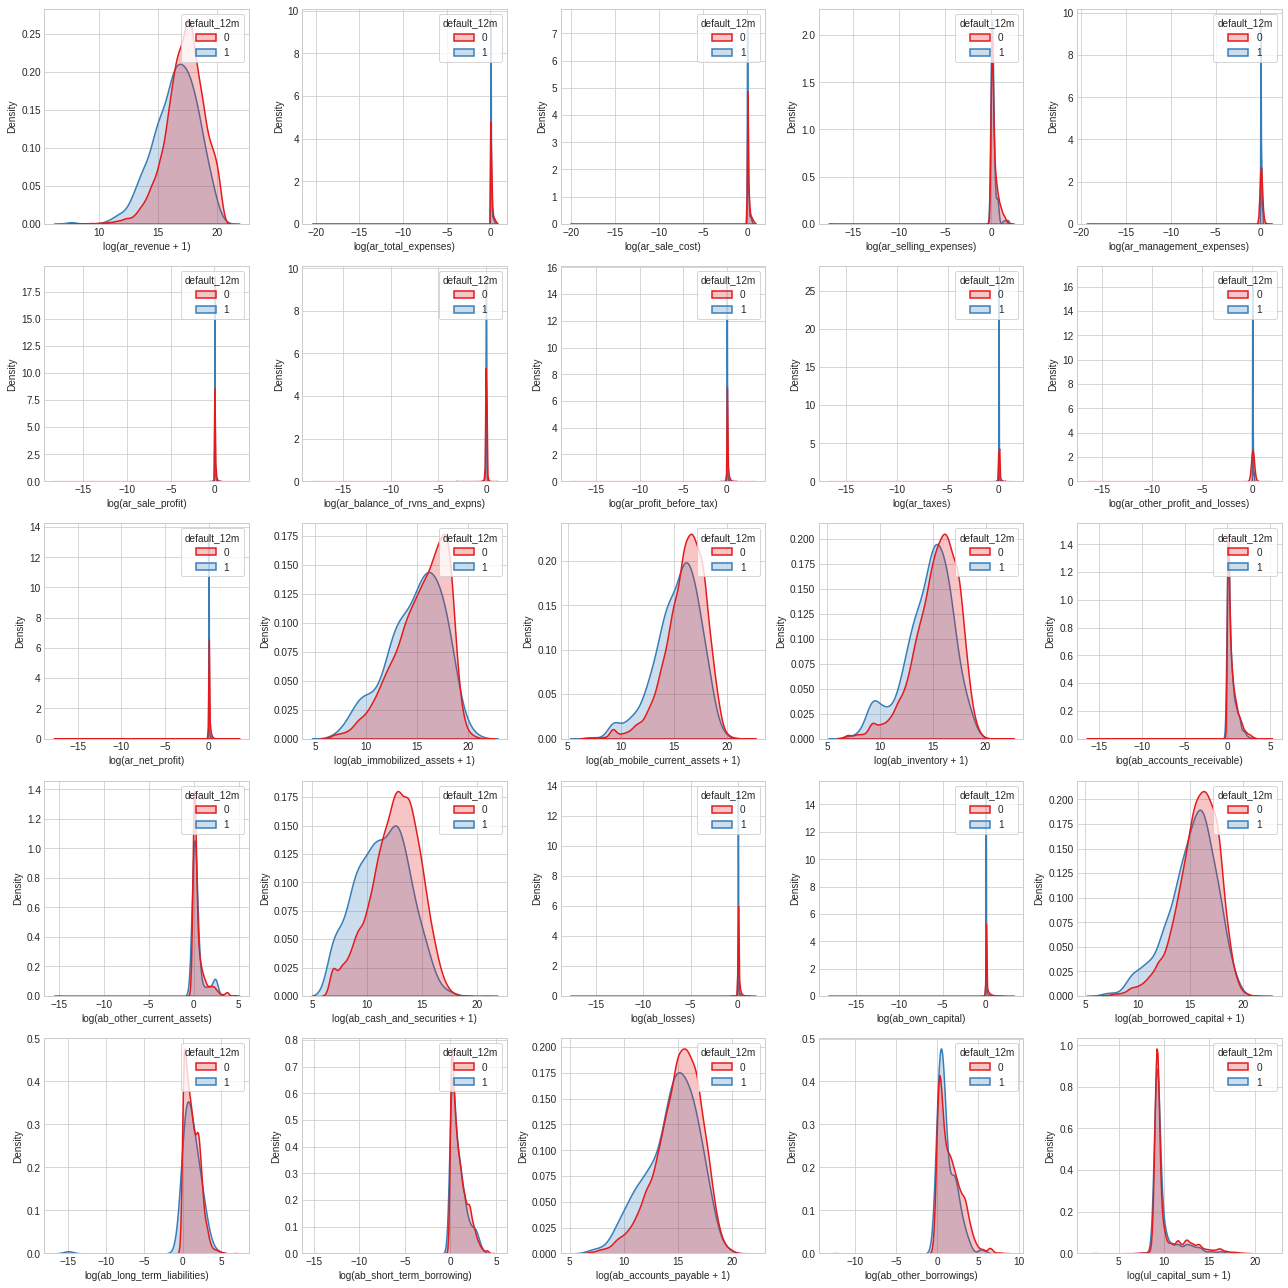

In [22]:
def plot_nz_logged_floats(train_df, features, nrows=5, ncols=5, figsize=(18, 18)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        slice_df = train_df[train_df[colname] != 0.0][colname]
        y = train_df['default_12m'].loc[slice_df.index]
        min_val = slice_df.min()
        if min_val < 0.0:
            abs_min = np.abs(min_val)
            slice_df = np.log((slice_df + abs_min + 1) / abs_min)
            ax.set_xlabel(f'log({colname})')
        else:
            slice_df = np.log1p(slice_df)
            ax.set_xlabel(f'log({colname} + 1)')
        sns.kdeplot(x=slice_df, hue=y, fill=True, linewidth=1.5, common_norm=False, ax=ax)

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_nz_logged_floats(train_df, floats)

Здесь уже можно вывести некоторые признаки, которые имеют более-менее адекватное распределение, которое хоть и очень отдаленно, но имеет очертания логнормального.

In [23]:
lognorm_features = ['ar_revenue', 'ab_immobilized_assets', 'ab_mobile_current_assets',
                 'ab_inventory', 'ab_cash_and_securities', 'ab_borrowed_capital', 'ab_accounts_payable']

In [24]:
train_df[lognorm_features].describe()

,ar_revenue,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_cash_and_securities,ab_borrowed_capital,ab_accounts_payable
count,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04
mean,4.341801e+07,4.796188e+06,1.621100e+07,8.665676e+06,8.577644e+05,1.288104e+07,8.031623e+06
std,1.015040e+08,2.695850e+07,4.863118e+07,2.840106e+07,7.829292e+06,4.483783e+07,2.868931e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.146000e+06,0.000000e+00,2.500000e+05,0.000000e+00,0.000000e+00,7.000000e+04,1.100000e+04
75%,3.624750e+07,0.000000e+00,1.266950e+07,5.558000e+06,3.130000e+05,8.401500e+06,4.335000e+06
max,7.946840e+08,1.630344e+09,3.175805e+09,2.890917e+09,1.271337e+09,3.349389e+09,1.820521e+09


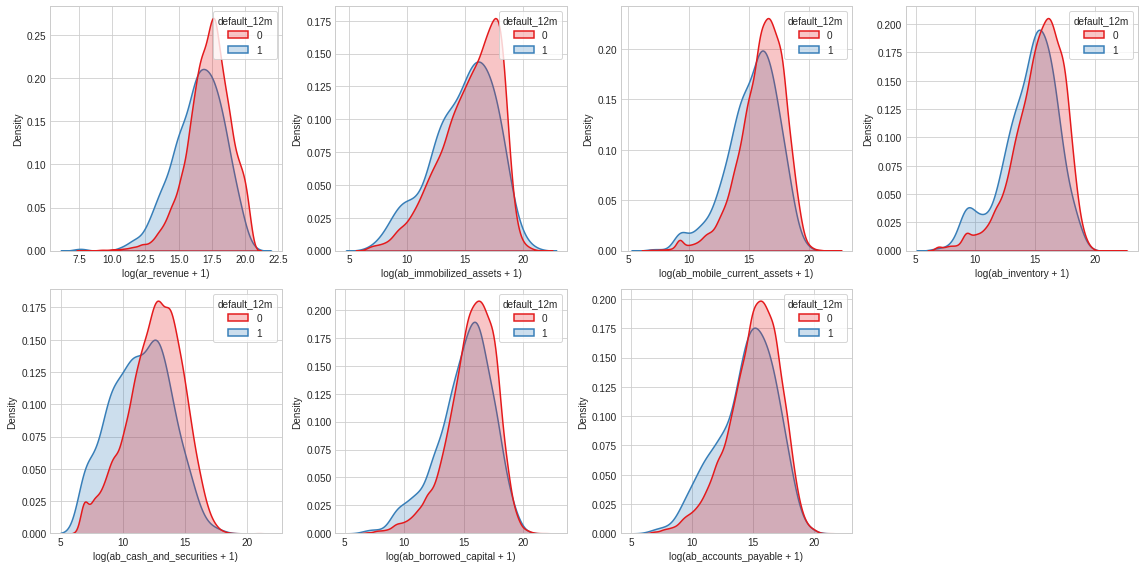

In [25]:
plot_nz_logged_floats(train_df, lognorm_features, nrows=2, ncols=4, figsize=(16, 8))

Минимальное значение -- ноль, что хорошо: можно просто преобразовать по $\log(x + 1)$.

Также можно выделить признаки, которые напоминают разумное одностороннее распределение.

Для разных меток таргета распределения немного разнятся, но я бы не сказал, что эта разница принципиальна. Уже на этом этапе мне кажется, что качество модели в большей степени будет зависеть от категориальных признаков, нежели чем от непрерывных.

In [26]:
onesided_features = ['ab_accounts_receivable', 'ab_other_current_assets', 'ab_long_term_liabilities',
                     'ab_short_term_borrowing', 'ab_other_borrowings', 'ul_capital_sum']

In [27]:
train_df[onesided_features].describe()

,ab_accounts_receivable,ab_other_current_assets,ab_long_term_liabilities,ab_short_term_borrowing,ab_other_borrowings,ul_capital_sum
count,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04
mean,7.114190e+06,4.311353e+05,1.676976e+06,2.653914e+06,5.185318e+05,1.366509e+06
std,2.888677e+07,6.013547e+06,2.023195e+07,1.022546e+07,1.091071e+07,1.502438e+07
min,-1.160400e+07,-3.413000e+06,-3.068000e+06,-2.700000e+06,-2.500000e+05,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04
75%,3.602500e+06,0.000000e+00,0.000000e+00,5.415000e+05,0.000000e+00,3.000000e+04
max,1.711586e+09,3.336220e+08,2.919676e+09,3.223740e+08,1.251578e+09,1.584979e+09


Три признака имеют нулевую третью квантиль. 

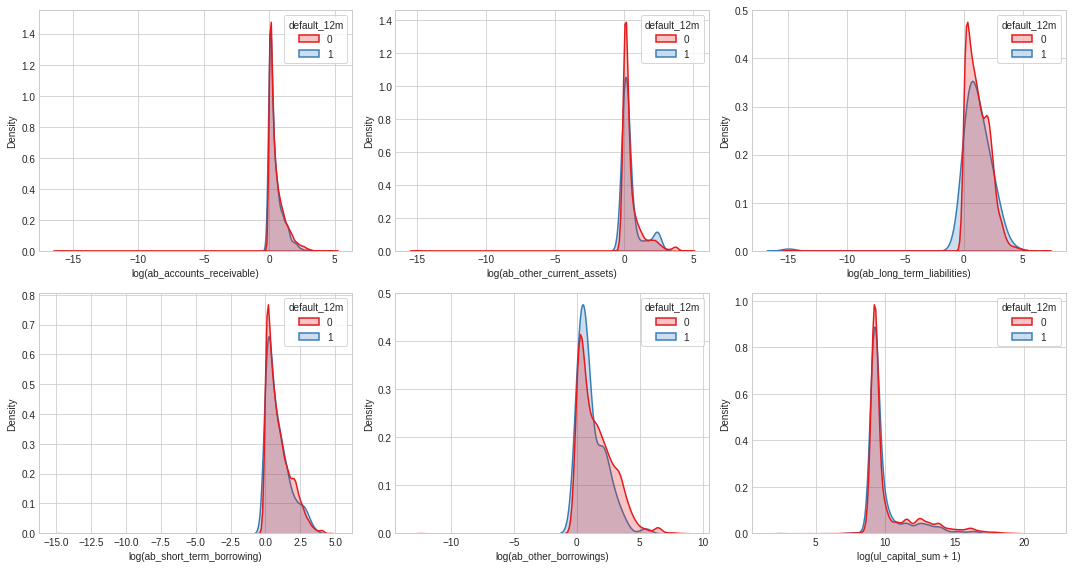

In [28]:
plot_nz_logged_floats(train_df, onesided_features, nrows=2, ncols=3, figsize=(15, 8))

Здесь я сделал преобразование $\log(\frac{x + |\min| + 1}{|\min|}) = \log(\frac{x + 1}{|\min|} + 1)$, чтобы моды этих признаков были сосредоточены вокруг нуля.

Остальные же признаки имеют моду (кроме потенциальной моды равной нулю), число объектов со значением которой превышает 8000-10000. Эти признаки, вероятно, не окажутся полезными.

In [29]:
highmode_features = list(set(floats) - set(lognorm_features) - set(onesided_features))
len(highmode_features)

12

In [30]:
train_df[highmode_features].describe()

,ab_losses,ab_own_capital,ar_total_expenses,ar_other_profit_and_losses,ar_taxes,ar_balance_of_rvns_and_expns,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_sale_cost,ar_net_profit,ar_profit_before_tax
count,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04,3.239500e+04
mean,1.761342e+06,1.018489e+07,4.088707e+07,2.096574e+04,2.230104e+05,-3.421125e+05,1.330797e+06,5.762936e+05,2.530931e+06,3.897998e+07,1.986774e+06,2.188819e+06
std,6.697304e+06,3.491861e+07,9.740292e+07,3.539720e+05,1.161170e+06,4.400683e+06,9.074624e+06,5.752833e+06,1.436102e+07,9.196597e+07,1.400593e+07,1.428986e+07
min,-4.780300e+07,-7.501000e+07,-7.019840e+08,-1.034000e+07,-1.681000e+07,-7.581800e+07,-3.542900e+07,-1.921670e+08,-9.210000e+07,-5.072780e+08,-4.778100e+07,-5.946600e+07
25%,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-1.690000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+04,9.090000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.580000e+05,0.000000e+00,0.000000e+00
75%,7.955000e+05,4.336000e+06,3.325550e+07,0.000000e+00,5.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.463000e+06,3.214700e+07,8.425000e+05,1.007000e+06
max,2.470140e+08,1.739879e+09,7.949360e+08,3.979500e+07,5.420200e+07,1.584250e+08,2.746560e+08,3.023550e+08,1.434511e+09,7.624930e+08,1.485559e+09,1.481526e+09


Кажется, что логарифм слишком сильно ужимает шкалу. Попробуем вывести графики без логарифма и проставим ylim, чтобы все стало повиднее.

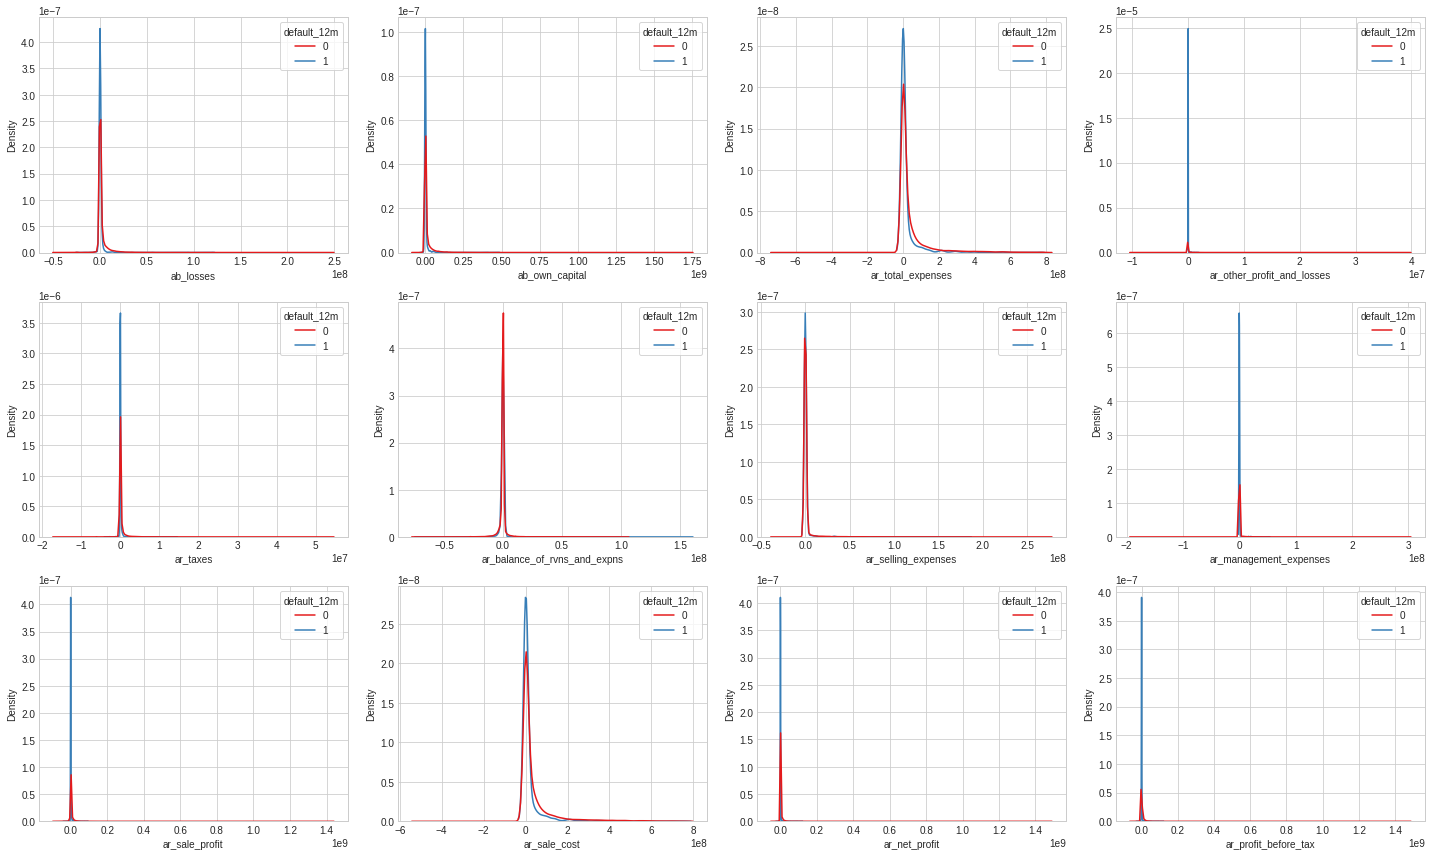

In [31]:
def plot_lim(train_df, features, nrows=5, ncols=5, ylim=1000, figsize=(20, 20)):
    lim_list_type = 11 if type(ylim) is list else 0
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        slice_df = train_df[colname]
        y = train_df['default_12m'].loc[slice_df.index]
        sns.kdeplot(x=slice_df, hue=y, linewidth=1.5, common_norm=False, ax=ax)
        # sns.histplot(x=slice_df, hue=y, bins=70, stat='density', element='poly', fill=False, common_norm=False, ax=ax)
        ax.set_xlabel(f'{colname}')
        if ylim is not None:
            if lim_list_type:
                ax.set_ylim([0, ylim[i]])
            else:
                ax.set_ylim([0, ylim])

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_lim(train_df, highmode_features, nrows=3, ncols=4, ylim=None, figsize=(20, 12))

Сложно сказать. Предлагаю не делать ничего особенного с этими признаками. Кажется, что логарифмирование делает только хуже, а что еще можно придумать -- мне не ясно. Единственное, что приходит на ум -- сделать дополнительный признак, который идентифицирует значение 0 (или же определенной длины бин), так как в области этого значения метка таргета 1 наиболее вероятна в этих признаках.

Я также отмечу, что ограничивать квантилью признаки не стоит: мы потеряем около 50% объектов.

In [32]:
quantiles = {}
tmp_df = train_df.copy()
for colname in floats:
    quantiles[colname] = tmp_df[colname].quantile(0.999)

for colname in floats:
    tmp_df = tmp_df[tmp_df[colname] <= quantiles[colname]]

tmp_df.shape[0]

32019

Потеряли почти половину объектов для значения верхней квантили 0.999.

In [33]:
FEATURES = {
    'lognorm': lognorm_features,
    'onesided': onesided_features,
    'highmode': highmode_features,
}

In [34]:
del tmp_df

#### Анализ остальных признаков

Пока что были рассмотрены только непрерывные признаки. Остальные признаки разобьем по категориям -- числовые дискретные и категориальные, проведем анализ и попробуем сгенерировать новые признаки.

In [35]:
cats = train_df.select_dtypes(exclude=float).columns
cats, len(cats)

(Index(['bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age',
        'cap_actual_age', 'ul_staff_range', 'ul_founders_cnt', 'ul_branch_cnt',
        'ul_strategic_flg', 'default_12m'],
       dtype='object'), 10)

Большинство этих признаков -- целочисленные. Выведем показатели.

In [36]:
train_df[cats].describe()

,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m
count,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000,32395.000000
mean,97.121500,78.644822,15.010341,15.010341,15.010341,11.946535,0.021670,0.000093,0.064547
std,75.555398,46.522534,9.546511,9.546511,9.546511,86.341847,0.342715,0.009623,0.245729
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,35.000000,35.000000,6.000000,6.000000,6.000000,1.000000,0.000000,0.000000,0.000000
50%,79.000000,77.000000,14.000000,14.000000,14.000000,1.000000,0.000000,0.000000,0.000000
75%,137.000000,133.000000,24.000000,24.000000,24.000000,2.000000,0.000000,0.000000,0.000000
max,921.000000,149.000000,33.000000,33.000000,33.000000,998.000000,20.000000,1.000000,1.000000


И описания этих признаков.

In [37]:
inds = desc_df[desc_df.field.isin(cats)].index
desc_cats = desc_df.loc[inds]
desc_cats['nunique'] = train_df[cats].nunique()[:-1].to_numpy()
desc_cats

,field,desc_rus,nunique
24,bus_age,Срок ведения бизнеса,315
25,ogrn_age,Срок с момента присваивания ОГРН,150
26,adr_actual_age,Срок с момента регистрации юридического адреса,33
27,head_actual_age,Срок с момента назначения руководителя,33
28,cap_actual_age,Срок с момента установки капитала,33
29,ul_staff_range,Количество сотрудников,3
31,ul_founders_cnt,Количество акционеров,278
32,ul_branch_cnt,Количество филиалов,13
33,ul_strategic_flg,Компания стратегического значения,2


Здесь сразу выделяются количественные дискретные признаки, и два категориальных: число сотрудников и флаг стратегического значения компании.

In [38]:
numeric = ['bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age',
       'cap_actual_age', 'ul_founders_cnt', 'ul_branch_cnt']

In [39]:
train_df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

`ul_staff_range` является порядковым категориальным признаком. В процессе моделирования кодировать его нужно по-особенному -- возможно, подойдет даже кодирование по метке.

In [40]:
categories = ['ul_strategic_flg', 'ul_staff_range']

Аналогично -- начнем с выявляения потенциально полезных и не очень признаков.

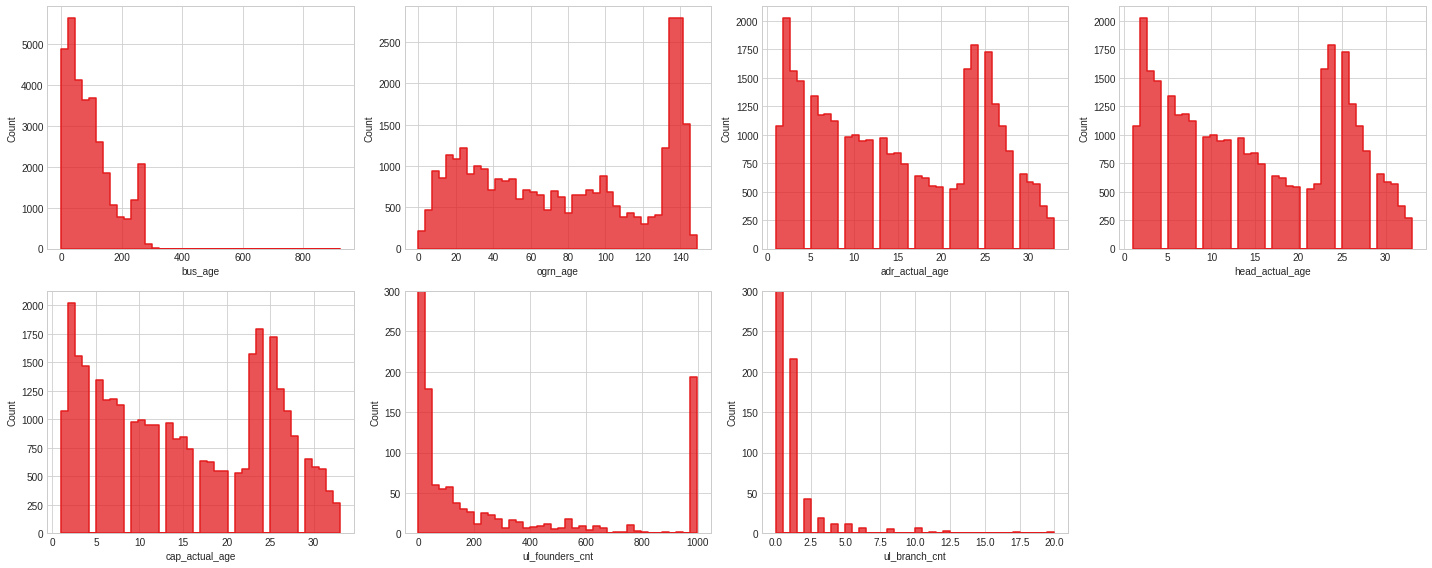

In [41]:
def plot_ints(train_df, features, nrows=2, ncols=4, ylim=300, figsize=(20, 8)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        sns.histplot(data=train_df, x=colname, bins=40, element='step', linewidth=1.5, ax=ax)
        ax.set_xlabel(f'{colname}')
        if i in [5, 6]:
            ax.set_ylim([0, ylim])

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


plot_ints(train_df, numeric)

Во-первых, признаки вида `***_actual_age` имеют практически одинаковое распределение -- имеет место проблема мультиколлинеарности, поэтому стоит оставить лишь один из этих признаков. Во-вторых, из этой картины уже можно выделить несколько бинарных признаков.

В признаках `bus_age`, `***_actual_age`, `ogrn_age`, `ul_founders_cnt` можно выделить два отрезка. Например, значение `***_actual_age=22` разграничивает две тенденции. Если смотреть на все это в общем, то можно вывести два довольно значимых признака-индикатора: старая ли компания, крупная ли компания. Надо лишь понять, как правильно это сделать.

В теории эти признаки могут оказаться важными, потому что у разных по зрелости компаний бизнес-процессы могут быть совершенно по-разному устроены, что естественным образом сказывается на экономических показателях организаций.

Исходя из этого можно вывести более сложный признак с помощью бининга: ввести уровни, как это сделано с числом сотрудников.

Посмотрим теперь, как эти признаки связаны с таргетом.

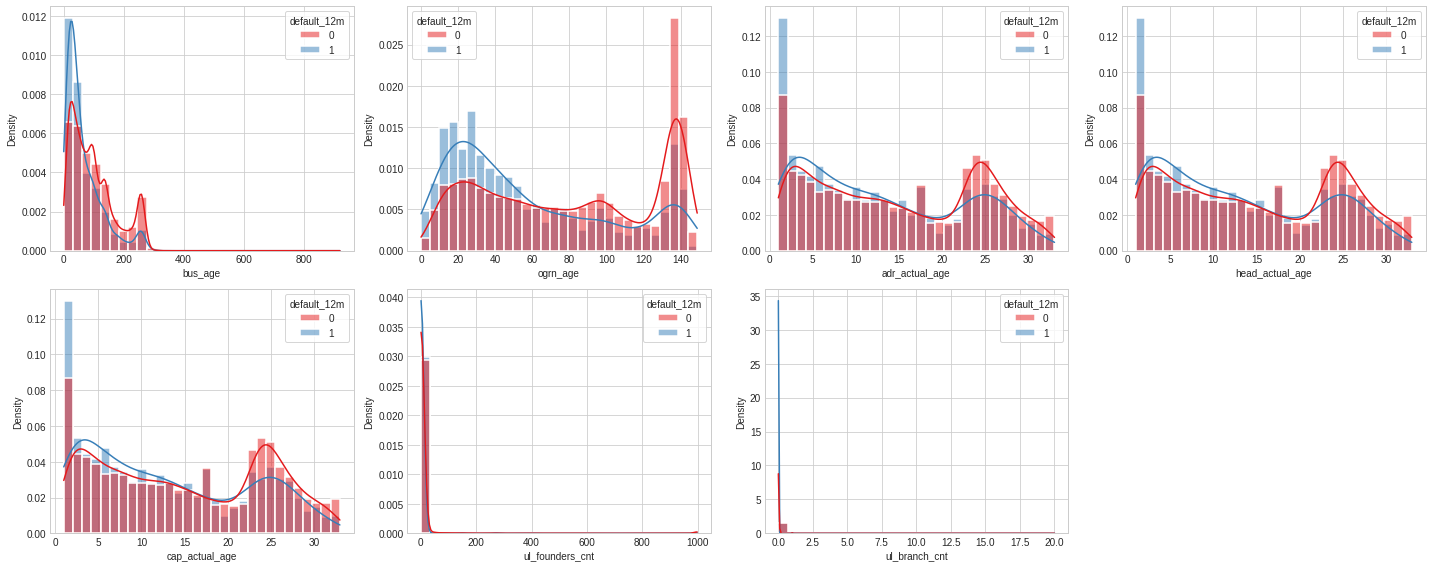

In [42]:
def plot_ints_hue(train_df, features, nrows=2, ncols=4, ylim=None, figsize=(20, 8)):
    lim_list_type = 1 if type(ylim) is list else 0
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    for i, colname in enumerate(features):
        ax = axes[i // ncols][i % ncols]
        sns.histplot(data=train_df, x=colname, hue='default_12m', bins=30, 
                     stat='density', kde=True, element='bars', linewidth=1.5, common_norm=False, ax=ax)
        ax.set_xlabel(f'{colname}')
        if ylim is not None:
            if lim_list_type:
                ax.set_ylim([0, ylim[i]])
            else:
                ax.set_ylim([0, ylim])

    for i in range(1, nrows * ncols - len(features) + 1):
        axes.flat[-i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


plot_ints_hue(train_df, numeric)

Есть полезные признаки. Попробуем логарифмировать два последних.

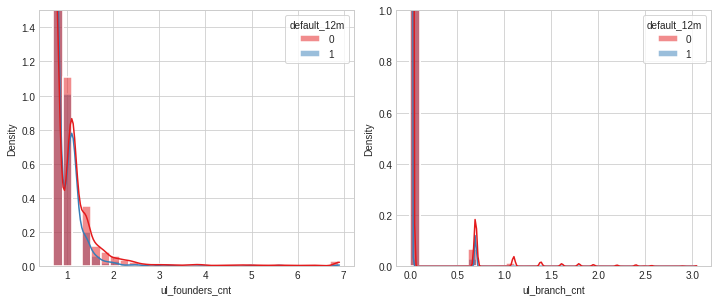

In [43]:
tmp_df = train_df[numeric[-2:] + ['default_12m']].copy()
tmp_df[numeric[-2:]] = np.log1p(train_df[numeric[-2:]])

plot_ints_hue(tmp_df, numeric[-2:], ylim=[1.5, 1])

С `ul_founders_cnt` стало получше, с `ul_branch_cnt` практически ничего не изменилось. В целом оба этих признака мало о чем говорят, не думаю, что они окажутся сильно полезными.

Давайте теперь выведем новые признаки. Выведем первые по `***_actual_age`.

In [44]:
prefix = ['adr', 'head', 'cap']
for pref in prefix:
    col = pref + '_actual_age'
    train_df[pref + '_ind'] = (train_df[col] >= 22).astype(int)

In [45]:
train_df[['adr_ind', 'head_ind', 'cap_ind']].sum(axis=1).unique()

array([0, 3])

Видим, что сумма либо 0, либо 3, значит, значения этих признаков полностью совпадают. Удалим лишние.

In [46]:
train_df.drop(columns=numeric[3:5] + ['head_ind', 'cap_ind'], inplace=True)
train_df.rename(columns={'adr_ind': 'age_ind'})

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,bus_age,ogrn_age,adr_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,age_ind
0,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,...,198,136,3,[1-100],50000.0,2,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256,135,12,[1-100],10000.0,5,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,33,28,[1-100],10000.0,2,0,0,0,1
3,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,...,185,139,8,[1-100],300000.0,1,0,0,0,0
4,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,...,220,138,27,[1-100],10000.0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32390,28264000.0,27911000.0,27911000.0,0.0,0.0,353000.0,-68000.0,285000.0,57000.0,0.0,...,71,71,5,[1-100],10000.0,1,0,0,0,0
32391,25017000.0,24381000.0,24381000.0,0.0,0.0,636000.0,0.0,636000.0,0.0,0.0,...,168,141,25,[1-100],600000.0,1,0,0,0,1
32392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11,11,11,[1-100],10000.0,1,0,0,0,0
32393,136162000.0,135088000.0,135088000.0,0.0,0.0,1074000.0,-719000.0,355000.0,267000.0,0.0,...,70,70,13,(100-500],11000.0,1,0,0,1,0


Аналогичную процедуру проведем и для остальных признаков.

In [47]:
train_df['bus_age_ind'] = (train_df['bus_age'] >= 200).astype(int)
train_df['ogrn_age_ind'] = (train_df['ogrn_age'] >= 120).astype(int)

Компания старая, если большой срок ведения бизнеса, много времени прошло с момента присваения ОГРН и т.д. Иными словами, дизъюнкция всех наших нововведенных признаков указывает на то, старая ли компания. По сути это означает сложение, и в какой-то степени сумму флагов можно понимать как уровень "старости". Пожалуй, стоит попробовать использовать такой признак. Остальные можно оставить.

In [48]:
indicators = ['adr_ind', 'bus_age_ind', 'ogrn_age_ind']
train_df['old_level'] = train_df[indicators].sum(axis=1)

Теперь можно определить, насколько крупная компания. Для этого можно использовать диапазон числа сотрудников, число акционеров и число филиалов.

In [49]:
staff_dict = { '[1-100]': 1, '(100-500]': 2, '> 500': 3 }
train_df['ul_staff_range'].replace(staff_dict, inplace=True)

In [50]:
train_df.ul_branch_cnt.value_counts()

0     32071
1       216
2        42
3        19
5        11
4        11
6         7
10        6
8         5
12        3
20        2
17        1
11        1
Name: ul_branch_cnt, dtype: int64

Признак числа филиалов вряд ли даст что-то адекватное. Количество акционеров, вероятно, стоит брать свыше 20 (> exp(3)).

In [51]:
train_df['ul_founders_cnt_ind'] = (train_df['ul_founders_cnt'] > 20).astype(int)
train_df['ul_founders_cnt'] = np.log1p(train_df['ul_founders_cnt'])

У крупной компании должна быть большая выручка. Можем заметить, что чем больше сотрудников, тем выше прибыль и выручка от реализации, тем больше капитал (все по средней статистике).

In [52]:
train_df.groupby('ul_staff_range')[['ar_revenue', 'ar_sale_profit', 'ab_own_capital', 'ul_capital_sum']].mean()

,ar_revenue,ar_sale_profit,ab_own_capital,ul_capital_sum
ul_staff_range,,,,
1,2.824617e+07,1.696604e+06,5.176634e+06,8.429565e+05
2,1.833664e+08,9.640702e+06,5.831924e+07,6.209273e+06
3,2.070281e+08,1.605556e+07,4.923364e+07,6.908953e+06


Компанию будем считать крупной, если флаг числа акционеров равен 1 и число сотрудников свыше 100.

In [53]:
train_df['big_comp_ind'] = train_df['ul_founders_cnt_ind'] * (train_df['ul_staff_range'] >= 2)

Проведем беглый анализ этих признаков.

In [54]:
train_df['big_comp_ind'].value_counts()

0    31936
1      459
Name: big_comp_ind, dtype: int64

Крупных компаний очень мало.

In [55]:
train_df['old_level'].value_counts()

0    14844
1    10915
2     5580
3     1056
Name: old_level, dtype: int64

Довольно много молодых компаний, старых все меньше и меньше по мере возрастания степени.

In [56]:
categories += ['ul_founders_cnt_ind', 'big_comp_ind', 'old_level'] + indicators
FEATURES['numeric'] = list(set(numeric) - set(['adr_actual_age', 'head_actual_age']))
FEATURES['categorical'] = categories
# to log1p
FEATURES['lognorm'] += ['ul_capital_sum']
FEATURES['onesided'] = list(set(FEATURES['onesided']) - set(['ul_capital_sum']))

In [57]:
assert np.sum([len(FEATURES[key]) for key in FEATURES]) == train_df.shape[1] - 1

In [58]:
abs_min = np.abs(train_df[FEATURES['onesided']].min()).to_numpy()
def custom_log(x):
    return np.log( (x + abs_min + 1) / abs_min )
        
train_df[FEATURES['lognorm']] = np.log1p(train_df[FEATURES['lognorm']])
train_df[FEATURES['onesided']] = custom_log(train_df[FEATURES['onesided']])

#### Парный анализ признаков

В этой части я хочу посмотреть на попарные взаимодействия и корреляции признаков. Возможно, получится получить какие-нибудь интересные инсайты и сгенерировать новые признаки.


Посмотрим, как от них зависит выручка и другие признаки от новых.

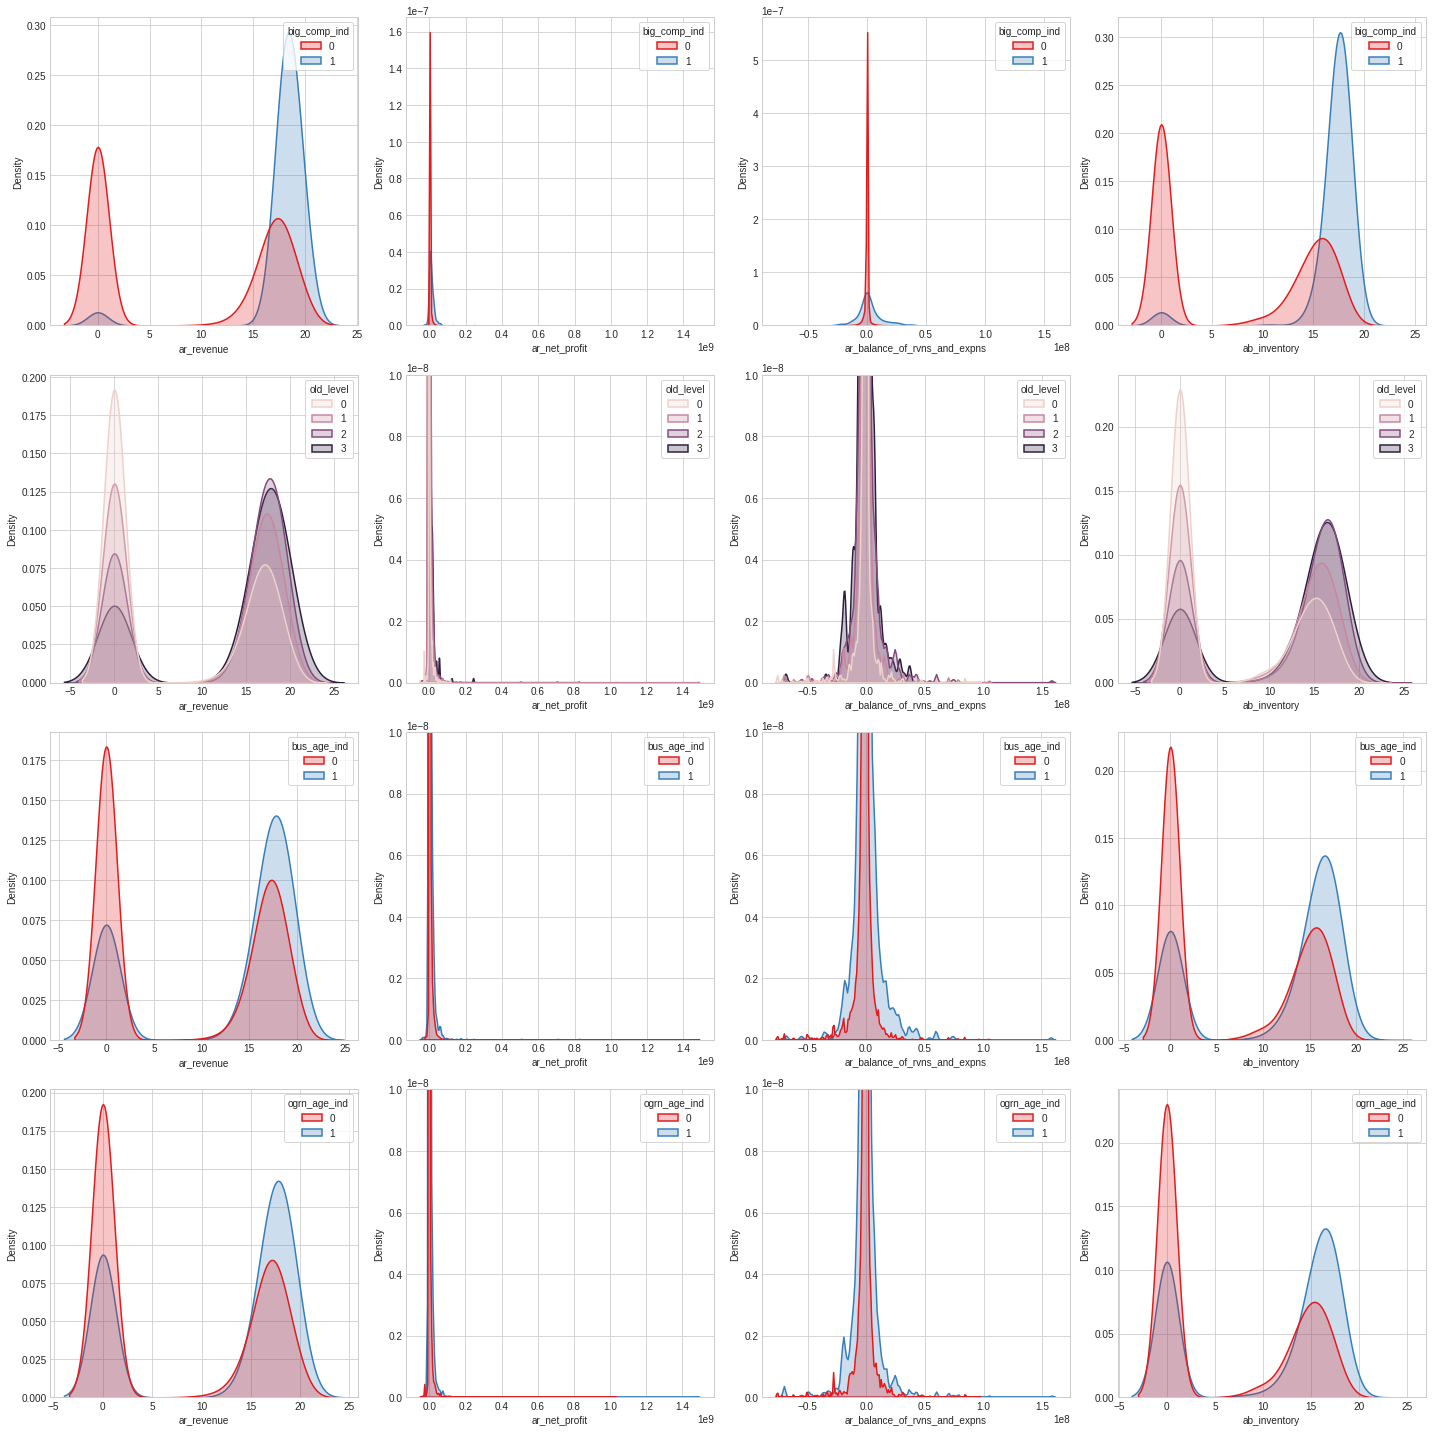

In [59]:
features = ['ar_revenue', 'ar_net_profit', 'ar_balance_of_rvns_and_expns', 'ab_inventory']
hues=['big_comp_ind', 'old_level', 'bus_age_ind', 'ogrn_age_ind']
fig, axes = plt.subplots(nrows=len(hues), ncols=len(features), figsize=(20, 20), squeeze=False)
for j, hue in enumerate(hues):
    for i, colname in enumerate(features):
        ax = axes[j][i]
        sns.kdeplot(data=train_df, x=colname, hue=hue, fill=True, linewidth=1.5, common_norm=False, ax=ax)
        ax.set_xlabel(colname)

for j in [1, 2, 3]:
    for i in [1, 2]:
        ax = axes[j][i]
        ax.set_ylim([0, 1e-8])

plt.tight_layout()
plt.show()

Польза от признака крупной компании действительно есть. Для `bus_age_ind` и `ogrn_age_ind` все выглядит похожим, вероятно, один из них лишний.

In [60]:
train_df.drop('bus_age_ind', axis=1, inplace=True)
FEATURES['categorical'] = list(set(FEATURES['categorical']) - set(['bus_age_ind']))

Признак по возрасту компании не особо полезен, имеет смысл его бинаризовать.

In [61]:
tmp_df = train_df[['ar_net_profit', 'old_level']].copy()
tmp_df['old_level'] = (tmp_df['old_level'] == 3).astype(int)

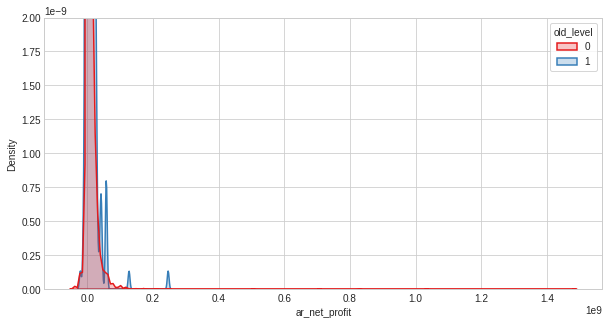

In [62]:
ax = sns.kdeplot(data=tmp_df, x='ar_net_profit', hue='old_level', fill=True, linewidth=1.5, common_norm=False)
ax.set_ylim([0, 2e-9])
plt.show()

Особо погоды не сделало. Оставим все как есть.

Похоже, что между признаками `ar_revenue` и `ab_inventory` есть мультиколлинеарность. Выведем корреляции.

In [63]:
train_df[['ar_revenue', 'ab_inventory', 'default_12m']].corr(method='spearman')

,ar_revenue,ab_inventory,default_12m
ar_revenue,1.000000,0.919361,-0.098290
ab_inventory,0.919361,1.000000,-0.091703
default_12m,-0.098290,-0.091703,1.000000


In [64]:
train_df.drop('ab_inventory', axis=1, inplace=True)

Вероятно, стоит анализировать долговые признаки -- вероятнее всего, из-за них и происходит дефолт.

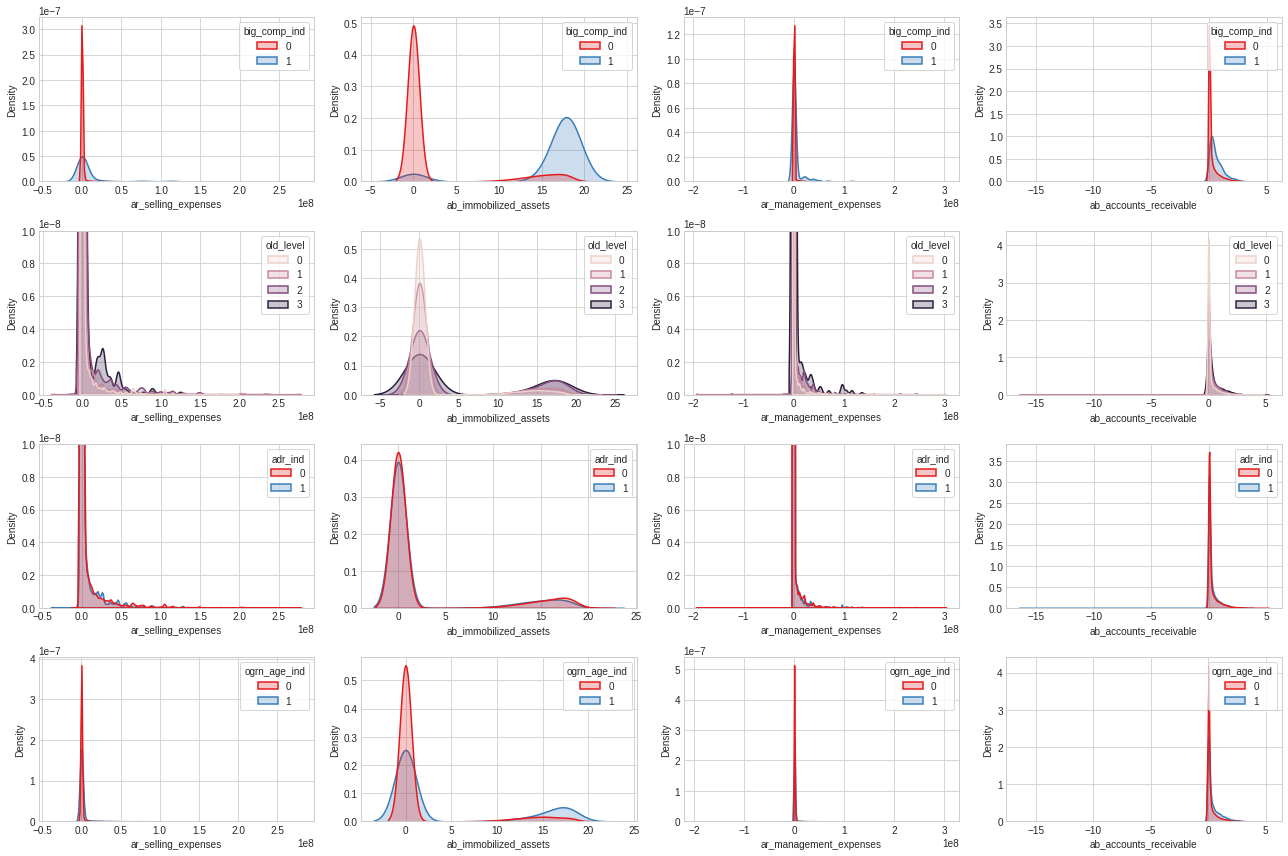

In [65]:
features = ['ar_selling_expenses', 'ab_immobilized_assets', 'ar_management_expenses', 'ab_accounts_receivable']
hues=['big_comp_ind', 'old_level', 'adr_ind', 'ogrn_age_ind']

fig, axes = plt.subplots(nrows=len(hues), ncols=len(features), figsize=(18, 12), squeeze=False)
for j, hue in enumerate(hues):
    for i, colname in enumerate(features):
        ax = axes[j][i]
        sns.kdeplot(data=train_df, x=colname, hue=hue, fill=True, linewidth=1.5, common_norm=False, ax=ax)
        ax.set_xlabel(colname)

for j in [1, 2]:
    for i in [0, 2]:
        ax = axes[j][i]
        ax.set_ylim([0, 1e-8])

plt.tight_layout()
plt.show()

`adr_ind` видно, что бесполезный признак. Тоже можно удалить.

Больше нет идей. Перейдем к моделированию.

In [66]:
train_df.drop('adr_ind', axis=1, inplace=True)
FEATURES['categorical'] = list(set(FEATURES['categorical']) - set(['adr_ind']))

#### Итоговые трансформации 

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lognorm, onesided):
        self.lognorm = lognorm
        self.onesided = onesided
        self.imputer = SimpleImputer(strategy='most_frequent')
        
    def fit(self, data):
        self.numeric = data.select_dtypes(include=float).columns
        self.imputer = self.imputer.fit(data[self.numeric])
        self.abs_min = np.abs(data[self.onesided].min())

        def custom_log(x):
            return np.log( (x + self.abs_min + 1) / self.abs_min )

        self.custom_log = custom_log
        return self
        
    def transform(self, data):       
        df_transformed = data.copy()
        df_transformed[self.numeric] = self.imputer.transform(df_transformed[self.numeric])
        df_transformed[self.lognorm] = np.log1p(df_transformed[self.lognorm])
        df_transformed[self.onesided] = self.custom_log(df_transformed[self.onesided])
        return df_transformed


class IntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        
    def fit(self, data):
        return self
        
    def transform(self, data):       
        df_transformed = data.copy()
        df_transformed['adr_ind'] = (df_transformed['adr_actual_age'] >= 22).astype(int)

        df_transformed['bus_age_ind'] = (df_transformed['bus_age'] >= 200).astype(int)
        df_transformed['ogrn_age_ind'] = (df_transformed['ogrn_age'] >= 120).astype(int)

        indicators = ['adr_ind', 'bus_age_ind', 'ogrn_age_ind']
        df_transformed['old_level'] = df_transformed[indicators].sum(axis=1)

        staff_dict = { '[1-100]': 1, '(100-500]': 2, '> 500': 3 }
        df_transformed['ul_staff_range'].replace(staff_dict, inplace=True)
        df_transformed['ul_founders_cnt_ind'] = (df_transformed['ul_founders_cnt'] > 20).astype(int)
        df_transformed['ul_founders_cnt'] = np.log1p(df_transformed['ul_founders_cnt'])

        df_transformed['big_comp_ind'] = df_transformed['ul_founders_cnt_ind'] * (df_transformed['ul_staff_range'] >= 2)
        df_transformed.drop(columns=['ab_inventory', 'adr_ind', 'bus_age_ind', 'head_actual_age', 'cap_actual_age'], inplace=True)
        return df_transformed


class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lognorm, onesided):
        self.lognorm = lognorm
        self.onesided = onesided
        self.floats_tr = FloatTransformer(lognorm, onesided)
        self.ints_tr = IntTransformer()
        
    def fit(self, data):
        self.floats_tr = self.floats_tr.fit(data)
        return self
        
    def transform(self, data):     
        df_transformed = data.copy()  
        df_transformed = self.floats_tr.transform(df_transformed)
        df_transformed = df_transformed.drop(columns=['record_id', 'ul_systematizing_flg'])
        df_transformed = self.ints_tr.transform(df_transformed)
        return df_transformed

## Обработка данных

In [68]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

In [69]:
train_df, valid_df = train_test_split(train_df, stratify=train_df.default_12m, test_size=0.3, random_state=10)
y_train, y_valid = train_df.default_12m, valid_df.default_12m
for df in [train_df, valid_df]:
    df.drop('default_12m', axis=1, inplace=True)
X_test = test_df.copy()

#### Кодирование и преобразование признаков

In [70]:
dt = DataTransformer(FEATURES['lognorm'], FEATURES['onesided']).fit(train_df)
X_train = dt.transform(train_df)
X_valid = dt.transform(valid_df)
X_test = dt.transform(X_test)

Здесь я заметил, что в `X_valid` есть строки с пропусками.

In [71]:
na_cols = ['ab_accounts_receivable', 'ab_other_current_assets']
X_valid[na_cols].fillna(X_train[na_cols].mode()).isna().sum()

ab_accounts_receivable     1
ab_other_current_assets    1
dtype: int64

In [72]:
X_valid[X_valid.isna().any(axis=1)][na_cols]

,ab_accounts_receivable,ab_other_current_assets
27758,2.112817,NaN
21817,NaN,8.710798e-07


Выглядит как будто бы минимальное значених этих столбцов в тренировочной выборке меньше минимального значения в валидационной.

In [73]:
dt.floats_tr.abs_min[na_cols]

ab_accounts_receivable      523000.0
ab_other_current_assets    1148000.0
dtype: float64

In [74]:
valid_df.loc[[27758, 21817]][na_cols]

,ab_accounts_receivable,ab_other_current_assets
27758,3803000.0,-3413000.0
21817,-11604000.0,0.0


In [75]:
valid_df[na_cols].min()

ab_accounts_receivable    -11604000.0
ab_other_current_assets    -3413000.0
dtype: float64

Стоит, вероятно, выкинуть такие значения: если всего по одному `NaN`, то скорее всего это выбросы.

In [76]:
X_valid.drop([27758, 21817], axis=0, inplace=True)
y_valid.drop([27758, 21817], axis=0, inplace=True)

Числовые признаки можно спокойно скалировать, а с категориальными, как водится, сложнее. Здесь по сути лишь пара категориальных признаков: порядковые `old_level` и `ul_staff_range`, остальные -- бинарные. Первые уже были закодированы а-ля `OrdinalEncoder`, используем как числовые. Бинарные признаки можно оставить такими же, а можно закодировать через `mean target`. В этот раз я хочу попробовать другой метод -- `Weight of Evidence`. Он кодирует метку в величину по ее степени влияния на таргет, и это может быть актуально для нашей задачи.

In [77]:
pip install -q category_encoders

     |████████████████████████████████| 72 kB 791 kB/s 


In [78]:
from category_encoders.woe import WOEEncoder

class ColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features_dict):
        self.features_dict = features_dict
        
    def fit(self, data, y=None):
        nunq = data.nunique()
        self.binary = set(nunq.loc[nunq == 2].index)
        self.all_nums = list(set(data.columns) - self.binary)
        self.binary = list(self.binary)
        floats = list(set(self.all_nums) - set(self.features_dict['numeric']) - set(self.binary))

        self.woe = WOEEncoder(cols=self.binary, random_state=10).fit(data, y)
        self.scaler = StandardScaler().fit(data[self.all_nums])
        return self
        
    def transform(self, data):     
        df_transformed = data.copy()  
        df_transformed = self.woe.transform(df_transformed)
        df_transformed[self.all_nums] = self.scaler.transform(data[self.all_nums])
        return df_transformed

In [79]:
coltr = ColumnsTransformer(FEATURES).fit(X_train, y_train)

In [80]:
X_train = coltr.transform(X_train)
X_valid = coltr.transform(X_valid)
X_test = coltr.transform(X_test)

#### Отбор признаков

Для этой задачи хорошо может подойти бустинг или случайный лес в силу особенностей деревьев, но для отбора признаков можно применить логистическую регрессию с $\ell 1$-регуляризацией.

In [81]:
from sklearn.linear_model import LogisticRegression as LogReg
from tqdm.notebook import tqdm

zeros = []
metric_vals = []
alphas = np.logspace(-3, 4, 10)
for alpha in tqdm(alphas):
    model_lasso = LogReg(penalty='l1', C=alpha, solver='liblinear', class_weight={0: 0.3, 1: 3}).fit(X_train, y_train)
    y_pred = model_lasso.predict(X_valid)
    metric_vals.append(ck_coeff(y_valid, y_pred))
    zeros.append(np.sum(model_lasso.coef_ == 0))

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
np.max(metric_vals)

0.10256147746732551

Это, пожалуй, самое высокое значение метрики, которое мне удалось добиться. Выше с логистической регрессией не получается.

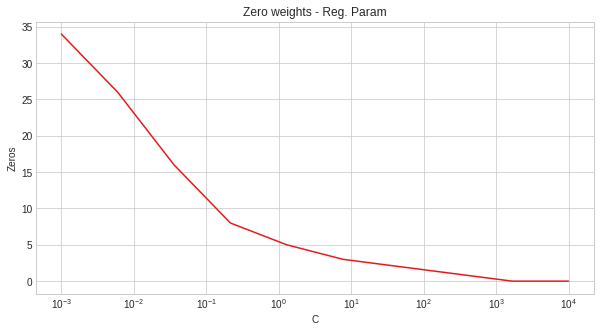

In [83]:
sns.lineplot(x=alphas, y=zeros)
plt.title('Zero weights - Reg. Param')
plt.xlabel('C')
plt.ylabel('Zeros')
plt.semilogx()
plt.show()

In [84]:
ind = np.argmax(metric_vals)
metric_vals[ind], alphas[ind], zeros[ind]

(0.10256147746732551, 0.21544346900318845, 8)

In [85]:
model_lasso = LogReg(penalty='l1', C=alphas[ind], solver='liblinear', class_weight={0: 0.3, 1: 3})
model_lasso = model_lasso.fit(X_train, y_train)

In [86]:
nulls = np.argwhere(model_lasso.coef_[0] == 0).reshape((-1))
X_train.columns[nulls]

Index(['ar_revenue', 'ar_total_expenses', 'ar_selling_expenses',
       'ar_profit_before_tax', 'ar_other_profit_and_losses', 'ar_net_profit',
       'ab_borrowed_capital', 'ul_strategic_flg'],
      dtype='object')

В целом -- адекватно. Признаки, на которые я рассчитывал в обнуление не попали, на что я и рассчитывал.

In [87]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score

y_pred = model_lasso.predict(X_valid)
roc_auc_score(y_valid, y_pred), recall_score(y_valid, y_pred), precision_score(y_valid, y_pred)

(0.6162713639785032, 0.45773524720893144, 0.12296486718080549)

На валидации неплохой `ROC-AUC`, значения метрик `precision` и `recall` малые, что плохо. Видимо, слишком сильный дисбаланс для этой задаче, и неплохо было бы применить дополнительные методы. О них в следующем подразделе.

Хочу сравнить с бейзлайном в драфте этого ноутбука.

In [88]:
from sklearn.model_selection import cross_val_score
features = ['bus_age','ul_capital_sum', 'ul_founders_cnt']

logit = LogReg(penalty='l1', C=alphas[ind], solver='liblinear', class_weight={0: 0.3, 1: 3})
cv_baseline = cross_val_score(logit, X_train[features], y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6536944524014083

0.6537 против 0.6483 на трех признаках. Значит, сделали что-то полезное, но сделали недостаточно.

#### Undersampling

В данный момент очень мало объектов положительного класса. Можно попробовать upsampling, но на мой взгляд распределения этого класса лучше всего не портить и не зашумлять. Вместо этого попробуем срезать число объектов отрицательного класса, чтобы процент положительных был хотя бы 10%. После этого сравним бейзлайны.

In [89]:
X_train.shape

(22676, 35)

In [90]:
pip install -q imbalanced-learn

In [91]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.11111, random_state=10)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled.shape

(14640, 35)

In [92]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    90.0
1    10.0
Name: default_12m, dtype: float64

In [93]:
def process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight):
    metric_vals = []
    alphas = np.logspace(-3, 4, 10)
    for alpha in tqdm(alphas):
        model_lasso = LogReg(penalty='l1', C=alpha, solver='liblinear', class_weight=class_weight).fit(X_resampled, y_resampled)
        y_pred = model_lasso.predict(X_valid)
        metric_vals.append(ck_coeff(y_valid, y_pred))

    ind = np.argmax(metric_vals)
    print(f'max CK: {metric_vals[ind]}, alpha: {alphas[ind]:.4f}')

In [94]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 0.4, 1: 2})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.10910516619474611, alpha: 0.0359


Не особо помогло -- + 0.7%. Попробуем другие методы.

`OneSidedSelection` -- очистка шумов через связи Томека (Tomek's links)

In [95]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection(sampling_strategy='not minority', n_neighbors=7, random_state=10, n_jobs=-1)
X_resampled, y_resampled = oss.fit_resample(X_train, y_train)
X_resampled.shape

(22292, 35)

In [96]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    93.432622
1     6.567378
Name: default_12m, dtype: float64

In [97]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 0.1, 1: 1})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.10110205989057917, alpha: 1.2915


`EditedNearestNeighbours` -- очищение от объектов, которые недостаточно удовлетворяют соседству.

In [98]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(sampling_strategy='not minority', n_neighbors=7, n_jobs=-1)
X_resampled, y_resampled = enn.fit_resample(X_train, y_train)
X_resampled.shape

(16122, 35)

In [99]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    90.919241
1     9.080759
Name: default_12m, dtype: float64

In [100]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 0.7, 1: 3})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.1067814952258268, alpha: 0.0359


`AllKNN` обобщает предыдущий алгоритм, позволяя повторные применение с последовательным увеличением числа ближайших соседей.

In [101]:
from imblearn.under_sampling import AllKNN

allknn = AllKNN(sampling_strategy='not minority', n_neighbors=7, n_jobs=-1)
X_resampled, y_resampled = allknn.fit_resample(X_train, y_train)
X_resampled.shape

(13417, 35)

In [102]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    89.08847
1    10.91153
Name: default_12m, dtype: float64

In [103]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 1.3, 1: 3.2})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.11084178979267015, alpha: 0.0060


Удалось поднять до 11%, однако было удалено очень много данных.

#### Oversampling

Срез выборки по мажорному классу хоть и дал прирост, но он незначителен. Все же стоит попробовать сэмплирование объектов положительного класса -- есть надежда, что это поможет.

Важно хорошо сэплировать объекты миноритарного класса, и здесь для этого есть SMOTE-like методы, которые основаны на принципе генерации объекта с помощью выпуклой комбинации через близжайших соседей.

`BorderlineSMOTE` -- исправляет проблему SMOTE, когда сгенерированные объекты миноритарного класса смешиваются с объектами мажоритарного, из-за чего возникнет путанница в распределениях классов. Придает больше значения граничным объектам, что может также подпортить распределение объектов (например, если кластеры объектов разных классов расположены далеко друг от друга, а граничные -- где-то посередине). 

In [104]:
X_train.shape

(22676, 35)

In [105]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(sampling_strategy=1/3, k_neighbors=7, random_state=10, n_jobs=-1)
X_resampled, y_resampled = bsmote.fit_resample(X_train, y_train)
X_resampled.shape

(28282, 35)

In [106]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    75.001768
1    24.998232
Name: default_12m, dtype: float64

In [107]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 1, 1: 1.5})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.1149545256475616, alpha: 0.0060


Относительно легко получилось поднять еще на полпроцента.

Суть `ADASYN` в адаптивной генерации объектов: там, где их мало -- будет сгенерировано больше. Для этого для каждой точки миноритарного класса алгорит смотрит на ее ближайших соседей и считает соотношение объектов мажоритарного класса среди к числу соседей -- плотность конкретного миноритарного объекта. По нему и определяется число сэмплов, которое будет сгенерировано вокруг этого объекта.

In [108]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy=1/3, n_neighbors=7, random_state=10, n_jobs=-1)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
X_resampled.shape

(28120, 35)

In [109]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    75.433855
1    24.566145
Name: default_12m, dtype: float64

In [110]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 0.8, 1: 1.5})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.11463120288082242, alpha: 0.0060


Аналогично, но чуть хуже.

`SVM-SMOTE` -- интереный алгоритм, который может оказаться крайне полезным в нашей задаче. Суть в выборе с помощью SVM объекта, через который будет проходить генерация новых сэмплов.

Основная мотивация -- в особенности SVM, благодаря которой он не чувствителен к несбалансированной выборке (N. Japkowicz and S. Stephen. The Class Imbalance Problem: A Systematic Study. Intelligent Data Analysis, Vol. 6(5) pp. 429-449, 2002), однако из-за разреженности объектов миноритарного класса разделяющая гиперплоскость смещается в сторону этих объектов, так как вероятность увидеть их вблизи границы мала.

Поэтому предлагается сгенерировать новые объекты вблизи гиперплоскости в виду того, что точки в этой области очень важны для оценки оптимальной границы принятия решения. Таким образом, это позволяет приблизить гиперплоскость к идеальной разделяющей границе, что несомненно увеличивает качество.

In [111]:
from imblearn.over_sampling import SVMSMOTE

smvsmote = SVMSMOTE(sampling_strategy=1/3, k_neighbors=7, m_neighbors=10, random_state=10, n_jobs=-1)
X_resampled, y_resampled = smvsmote.fit_resample(X_train, y_train)
X_resampled.shape

(28282, 35)

In [112]:
vc = y_resampled.value_counts() / X_resampled.shape[0] * 100
vc

0    75.001768
1    24.998232
Name: default_12m, dtype: float64

In [113]:
process_model(X_resampled, y_resampled, X_valid, y_valid, class_weight={0: 0.7, 1: 1})

  0%|          | 0/10 [00:00<?, ?it/s]

max CK: 0.12062406916219932, alpha: 0.0060


Подняли еще на полпроцента. Хорошо. Посмотрим, как изменился бейзлайн.

In [114]:
logit = LogReg(penalty='l1', C=0.0060, solver='liblinear', class_weight={0: 0.7, 1: 1})
cv_baseline = cross_val_score(logit, X_resampled[features], y_resampled, cv=5, scoring='roc_auc').mean()
cv_baseline

0.7668837035017587

Было 0.6537 против 0.6483 на трех признаках, стало 0.7669 против 0.6537. Отлично.

Я также пробовал использовать комбинацию этих техник, но это не дало лучшего прироста, поэтому останавливаюсь только на оверсэмплинге. 

Отмечу еще, что для приведения соотношений можно использовать `NearMiss`, но у меня с ним не задалось: слишком долго работает, а без хорошего подбора гиперпараметров результаты посредственные. Ранее использовал, в этой работе же попытался дать второй шанс. Не оправдал ожиданий.

## Моделирование

В качестве модели выбираю привычный мне `CatBoost` с подбором порога классификации. Чтобы подбирать порог правильно -- по "правильным" вероятностям, нам будет необходима калибровка, так как работаем мы с нелинейной моделью -- этот класс алгоритмов не склонен к предсказанию вероятностей из коробки (как это делает по определению логистическая регрессия), поэтому нужно править отдельным алгоритмом. С другой стороны, мне крайне интересно, как поведет себя калибровка на несбалансированной задаче.

Для бинарной классификации с дисбалансом `CatBoost` предлагает встроенные методы для балансировки вклада того или иного класса в значения лосса. Будем использовать `scale_pos_weight`.

Оптимизируем гиперпараметры через `optuna`.

In [115]:
pip install -q catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [116]:
pip install -q optuna

     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 209 kB 58.3 MB/s 
     |████████████████████████████████| 81 kB 4.9 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 112 kB 59.1 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 147 kB 57.2 MB/s 


In [117]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier as CatBoost
import optuna
from optuna import distributions as optdists
optuna.logging.set_verbosity(optuna.logging.WARNING)

X_train = X_resampled.copy()
y_train = y_resampled.copy()

Будем оптимизировать каппу Коэна, хотя можно для этого использовать `ROC-` или `PR-AUC`, что, может быть, было бы даже правильнее в некотором смысле. В частности, когда-то для задачи с сильным дисбалансом классов (доля положительных объектов менее 1 процента) я оптимизировал `PR-AUC`. В этот раз мне интересно посмотреть именно на результаты оптимизации целевой метрики.

Оценивать качество будем по валидационной выборке: если смотреть по кросс-валидации, то мы получим высокое значение метрики на кросс-валидации, а на тесте все будет печально (проверено, хотя это и было ожидаемо). Подбирать параметры я буду тоже по валидации, что не совсем корректно, но в целом имеет место быть.

Обучим чистый бустинг и посмотрим, что получится.

In [118]:
estimator = CatBoost(verbose=0, random_state=10).fit(X_train, y_train)
train_preds, valid_preds = estimator.predict(X_train), estimator.predict(X_valid)
ck_coeff(y_train, train_preds), ck_coeff(y_valid, valid_preds)

(0.8056792615499443, 0.027327770565206178)

Жесткое переобучение, что неудивительно. На самом деле такая картина будет наблюдаться и далее, так как баланс классов в выборках совершенно разный, и в целом это нормально. Основная задача -- увеличить скор на валидации. Если увеличение на трейне будет не особо сильным (например, мы не получим единицу), то все хорошо.

Впрочем, уже здесь мне видно, что бустинг будет гораздо эффективнее (мощнее) логистической регрессии -- по моему опыту с такими (я бы сказал) смешанными распределениями с нечетким разделениям алгоритмы на решающих деревьях показывают себя лучше.

In [119]:
def objective_cb(trial, scoring):
    estimator = CatBoost()
    
    params = {   
            'iterations':          trial.suggest_int('iterations', low=50, high=500, step=50),
            'depth':               trial.suggest_int('depth', low=4, high=12, step=2),
            'l2_leaf_reg':         trial.suggest_float('l2_leaf_reg', low=0.05, high=5, step=0.05),
            'bagging_temperature': trial.suggest_float('bagging_temperature', low=0.0, high=1, step=0.1),
            'learning_rate':       trial.suggest_float('learning_rate', low=0.02, high=0.5, step=0.02),  
            'scale_pos_weight':    trial.suggest_float('scale_pos_weight', 0.2, 10, step=0.2),  
            'task_type': 'GPU',
            'devices': '0:1',
            'verbose': 0, 
            'random_state': 10,
        }
       
    estimator.set_params(**params)
    estimator = estimator.fit(X_train, y_train)
    return scoring(y_valid, estimator.predict(X_valid))

In [120]:
def study_results(study, scoring_name='Cohen\'s kappa'):
    trial = study.best_trial
    print('Trials done: {}\n'.format(len(study.trials)))
    print('Best {} score: {:.6}\n'.format(scoring_name, trial.value))
    print('Best params:\n')
    display(trial.params)


def plot_study(study):
    fig_list = [
        optuna.visualization.plot_optimization_history(study),
        optuna.visualization.plot_param_importances(study),
    ]
    
    for fig in fig_list:
        fig.update_layout(width=900)
        fig.show()

In [121]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(
    lambda trial: objective_cb(trial, ck_coeff), n_trials=200, timeout=6000, gc_after_trial=True,
)
study_results(study_cb)
plot_study(study_cb)

Trials done: 200

Best Cohen's kappa score: 0.164914

Best params:



{'iterations': 350,
 'depth': 8,
 'l2_leaf_reg': 4.05,
 'bagging_temperature': 0.1,
 'learning_rate': 0.30000000000000004,
 'scale_pos_weight': 3.6000000000000005}

In [122]:
from sklearn.metrics import roc_curve, auc

def draw_ROC(model, X, y, title='CatBoost', ax=None):
    plt.rcParams["figure.figsize"] = (8, 8)
    if ax is None:
        ax = plt.gca()
        
    probas = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, probas)
    ax.plot(fpr, tpr, color='royalblue', label='roc-curve', linewidth=2)
    ax.plot([0, 1], [0, 1], color='lime', linestyle='dashed', linewidth=2)
    auc_roc = auc(fpr, tpr)
    ax.text(0.08, 0.9, 'AUC: {:.4f}'.format(auc_roc), transform=ax.transAxes,
                bbox=dict(boxstyle='square', facecolor='gray', alpha=0.16))
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title('{} ROC Curve'.format(title))
    return ax

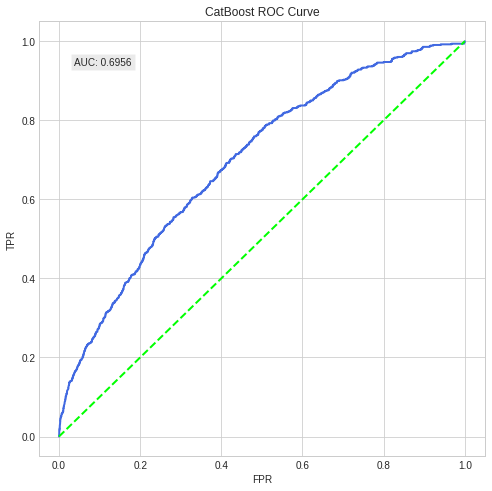

In [123]:
cb_params = study_cb.best_trial.params
cb_tuned = CatBoost(**cb_params, verbose=0, random_state=10).fit(X_train, y_train)
draw_ROC(cb_tuned, X_valid, y_valid)
plt.show()

In [124]:
ck_coeff(y_valid, cb_tuned.predict(X_valid))

0.14486805054354188

Обучили -- отлично -- получили что-то адекватное: 70% `ROC-AUC` на валидации выглядит приятно. Как и ожидалось, вклад минорного класса в лосс является решающим параметром.

Теперь применим калибровку вероятностей и подберем порог. Иногда такой простой метод способен ощутимо поднять качество, а иногда нет. Посмотрим, как будут выглядеть калибровочные кривые.

In [125]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline

def plot_calibration_curve(model, X_train, y_train, X_test, y_test, n_bins=5, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    def compute_bins(X, y):
        preds = model.predict_proba(X)[:, 1]
        bin_middle_points = []
        bin_real_ratios = []
        for i in range(n_bins):
            l = 1.0 / n_bins * i
            r = 1.0 / n_bins * (i + 1)
            bin_middle_points.append((l + r) / 2)
            bin_real_ratios.append(np.mean(y[(preds >= l) & (preds < r)] == 1))
        return bin_middle_points, bin_real_ratios
        
    bin_middle_points_tr, bin_real_ratios_tr = compute_bins(X_train, y_train)
    bin_middle_points_val, bin_real_ratios_val = compute_bins(X_valid, y_valid)

    ax.plot(bin_middle_points_tr, bin_real_ratios_tr, color='royalblue', linewidth=2, label='train')
    ax.plot(bin_middle_points_val, bin_real_ratios_val, color='lime', linewidth=2, label='valid')
    ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', linewidth=1)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Segment center')
    ax.set_ylabel('Fracture of positive predictions')
    if title is not None:
        ax.set_title(title)
    ax.grid()
    return ax

In [135]:
from sklearn.model_selection import StratifiedKFold

CV = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
cb_tuned_ = CatBoost(**cb_params, verbose=0, random_state=10)
cb_calibr = CalibratedClassifierCV(base_estimator=cb_tuned, method='isotonic', cv=CV, ensemble=True, n_jobs=-1).fit(X_train, y_train)

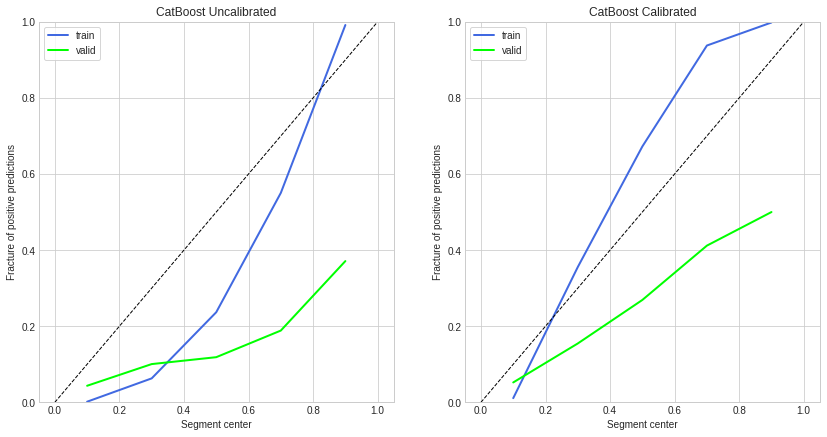

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_calibration_curve(cb_tuned, X_train, y_train, X_valid, y_valid, title='CatBoost Uncalibrated', ax=axes[0])
plot_calibration_curve(cb_calibr, X_train, y_train, X_valid, y_valid, title='CatBoost Calibrated', ax=axes[1])
for ax in axes:
    ax.grid()
    ax.legend()
plt.show()

Кажется, что калибровка особо не помогла. Ранее я не видел такой картины: калибровочная кривая на валидации не доходит до 1, это говорит о завышенном прогнозе, видимо, так влияет дисбаланс -- мотивация почитать статьи на эту тему.

Впрочем, это все равно может помочь при подборе порога. Сравним две модели и посмотрим, где значение метрики выше.

In [137]:
def find_threshold(model, X_valid, y_valid):
    thresholds = np.arange(0.1, 1.0, 0.05)
    metric_vals = {}
    for tr in thresholds:
        proba = model.predict_proba(X_valid)[:, 1]
        metric_vals[tr] = ck_coeff(y_valid, proba, treshold=tr, mode='proba')
    threshold, value = max(metric_vals.items(), key = lambda k : k[1])
    print(f'Threshold: {threshold:.2f}\nCohen\'s kappa: {value:.6f}')
    return threshold, value

In [138]:
tr, val = find_threshold(cb_tuned, X_valid, y_valid)

Threshold: 0.50
Cohen's kappa: 0.144868


In [139]:
tr_calibr, val_calibr = find_threshold(cb_calibr, X_valid, y_valid)

Threshold: 0.20
Cohen's kappa: 0.164503


Я хотел бы еще поанализировать важность признаков с помощью `shap`, как я делал это [здесь](https://github.com/necroshine0/ds-notebooks/blob/main/churn/4-modeling.ipynb), но, к сожалению, рискую не успеть к дедлайну.

## Формирование файла с ответом

In [140]:
model = cb_tuned if val > val_calibr else cb_calibr
opt_treshold = tr if val > val_calibr else tr_calibr

In [141]:
probas_test = model.predict_proba(X_test)[:, 1]
preds_test = (probas_test >= opt_treshold).astype(int)

In [142]:
tmp_df = pd.read_csv('PD-data-test.csv', sep=';')
answ_df = tmp_df[['record_id']].rename(columns={'record_id': 'id'})
assert answ_df.shape[0] == preds_test.shape[0]
answ_df['predict'] = preds_test

In [143]:
answ_df.to_csv('PD-submit-necroshine0.csv', index=False, sep=';')

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords-new/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

**Мой результат в лидерборде:** 0.565.

Увы, ожидал большего. Возможно, применение `mean target` или `one hot` кодирование дало бы лучшие результаты, да и работа с числовыми признаками скорее всего тоже подкачала. На что я сетую больше всего -- недостаточно полезных признаков было создано.